In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[0]
sys.path.append(str(path_root))
%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import multivariate_normal

In [3]:
from steinRF.srfr import srfr
from steinRF.mar_srfr import mar_srfr
from steinRF.utils import gp_cross_val, metric_model, run_hyperopt, animate_particles
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates.jax import distributions as tfd
import optax
import equinox as eqx
from jax.lib import xla_bridge
import seaborn as sns
import optuna

2024-01-28 16:11:13.968758: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 16:11:13.968794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 16:11:13.969366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 16:11:14.499439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
from solstice.kernels import RFF, NonstationaryRFF
from solstice.gp import LowRankGP, fitgp
from solstice.transforms import ARD, NNTransform, DeepRFF

In [5]:
from steinRF.baselines import build_svgp, train_svgp, orthogonal_gaussian

In [6]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


In [7]:
key = jax.random.PRNGKey(0)

## Data

In [8]:
class star_gaussian(object):
	def __init__(self, skewness, n):
		self.d = 2
		self.dimension = 2
		self.K = n
		theta = 2*np.pi/n
		U = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])

		self.mu = np.zeros([self.K, self.d])
		self.sigma = np.zeros([self.K, self.d, self.d])
		self.inv_sigma = np.zeros_like(self.sigma)

		self.mu[0,:] = 1.5 * np.array([1.,0.])
		self.sigma[0,:,:] = np.diag([1.,1./skewness])
		self.inv_sigma[0,:,:] = np.diag([1.,skewness])

		for i in range(1,n):
			self.mu[i,:] = np.matmul(U,self.mu[i-1,:])
			self.sigma[i,:,:] = np.matmul(U, np.matmul(self.sigma[i-1,:,:],U.T))
			self.inv_sigma[i,:,:] = np.matmul(U, np.matmul(self.inv_sigma[i-1,:,:],U.T))

		self.mean = np.mean(self.mu)
		self.x2 = self.mean * self.mean * self.K
		for i in range(self.K):
			self.x2 += np.diag(self.sigma[i,:,:])
		self.x2 /= self.K

	def sample(self, n_samples):
		n = int(n_samples/self.K)
		x = np.zeros([self.K * n, self.d])
		for k in range(self.K):
			x[k*n:(k+1)*n,:] = np.random.multivariate_normal(self.mu[k,:], self.sigma[k,:,:], n)
		np.random.shuffle(x)
		return x

	def logp(self, x):
		n,d = x.shape
		Fx = np.zeros(n)
		for k in range(self.K):
			pdfi = multivariate_normal.pdf(x, mean = self.mu[k,:], cov = self.sigma[k,:,:])
			Fx += pdfi
		return np.log(Fx / self.K)

	def grad_log_p(self, x):
		n = x.shape[0]
		Fx = np.zeros(n)
		Jx = np.zeros_like(x)
		for k in range(self.K):
			pdfi = multivariate_normal.pdf(x, mean = self.mu[k,:], cov = self.sigma[k,:,:]) + 1e-20
			Fx += pdfi
			Jx += pdfi[:, None] * np.matmul(self.mu[k,:] - x, self.inv_sigma[k,:,:])
		return Jx/Fx[:, None]

	def Hessian_log_p(self, x):
		n, d = x.shape
		Fx = np.zeros(n)
		Hx = np.zeros([n,d,d])
		for k in range(self.K):
			pdfi = multivariate_normal.pdf(x, mean = self.mu[k,:], cov = self.sigma[k,:,:]) + 1e-20
			Fx += pdfi
			Hx += pdfi[:, None, None] * self.inv_sigma[k,:,:]
		return Hx/Fx[:, None, None]

	def inv_avg_Hessian(self, Q):
		return np.linalg.inv(Q)

In [9]:
env = star_gaussian(10, 5)
bound = 4
N = 5000
X = jax.random.uniform(key, shape = (N, 2), minval=jnp.array([-bound, -bound]), maxval=jnp.array([bound, bound]))
y = jnp.exp(env.logp(X))
# y += jax.random.normal(key, shape = y.shape) * 0.01

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train += jax.random.normal(key, shape = y_train.shape) * 0.01

### Plotting and Eval Utilities

In [10]:
# plotting helpers
n_per_dim = 100
X1_plot, X2_plot = np.meshgrid(np.linspace(-4, 4, n_per_dim), np.linspace(-4, 4, n_per_dim))
X_plot = jnp.concatenate([X1_plot[:, :, None], X2_plot[:, :, None]], axis=-1)
y_plot = jnp.exp(env.logp(X_plot.reshape(-1, 2))).reshape(n_per_dim, n_per_dim)

In [11]:
def pre_post_plot_w(w_pre, w_post):
    sns.scatterplot(x=w_pre[:,0], y=w_pre[:,1], label = 'pre', color = 'blue')
    sns.scatterplot(x=w_post[:,0], y=w_post[:,1], label = 'post', color = 'orange')
    plt.show()

def pre_post_plot_preds(X, y, y_pre, y_post, **kwargs):
    s1 = kwargs.get('s1', 15)
    s2 = kwargs.get('s2', 15)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    angles = kwargs.get('angles', (30, 45))
    ax.view_init(elev=angles[0], azim=angles[1])
    ax.plot_surface(X1_plot, X2_plot, y_plot, cmap='viridis', alpha=0.25)
    ax.scatter(X[:,0], X[:,1], y_pre, label='Pre', s=s1)
    ax.scatter(X[:,0], X[:,1], y_post, label='Post', s=s2)
    ax.set_title('Predictions')
    ax.legend()
    plt.show()

def loss_plot(losses):
    # first plot
    fig = sns.lineplot(x=np.arange(losses.shape[0]), y=losses[:, 1])
    fig.set_title('Losses')

def pre_post_plots(X, losses, w_pre, w_post, y_pre, y_post, **kwargs):
    s1 = kwargs.get('s1', 15)
    s2 = kwargs.get('s2', 15)

    # Create figure and axes
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(131)  # First subplot on the left
    ax2 = fig.add_subplot(132)  # Second subplot in the middle
    ax3 = fig.add_subplot(133, projection='3d')  # Third subplot on the right

    # first plot
    sns.lineplot(x=np.arange(losses.shape[0]), y=losses[:, 1], ax=ax1)
    ax1.set_title('Losses')

    # second plot
    sns.scatterplot(x=w_pre[:,0], y=w_pre[:,1], color='blue', ax=ax2, label='pre', s=s1)
    sns.scatterplot(x=w_post[:,0], y=w_post[:,1], color='orange', ax=ax2, label="post", s=s1)
    ax2.set_title('Particles')

    # third plot
    angles = kwargs.get('angles', (30, 45))
    ax3.view_init(elev=angles[0], azim=angles[1])
    ax3.plot_surface(X1_plot, X2_plot, y_plot, cmap='viridis', alpha=0.25)
    ax3.scatter(X[:,0], X[:,1], y_pre, label='Pre', s=s2)
    ax3.scatter(X[:,0], X[:,1], y_post, label='Post', s=s2)
    ax3.set_title('Predictions')
    ax3.legend()

    plt.show()

def error_plots():
    pass

In [12]:
def plot_kernel(k, n_ticks=10):
    d = X_plot.shape[-1]
    y = k(X_plot.reshape(-1, d), jnp.zeros(d)).reshape(n_per_dim, n_per_dim)
    # plt.contour(X1_plot, X2_plot, y, cmap='viridis')
    # sns.heatmap(y)
    # Create the heatmap
    ax = sns.heatmap(y)

    # Set tick labels for x and y axes
    tick_positions = np.arange(0, n_per_dim, n_ticks+1)
    tick_labels = np.linspace(start=X_plot[:, :, 0].min(), stop=X_plot[:, :, 0].max(), num=n_per_dim)[tick_positions]
    formatted_tick_labels = [f"{label:.2f}" for label in tick_labels]
    ax.set_xticks(tick_positions + 0.5, minor=False)
    ax.set_yticks(tick_positions + 0.5, minor=False)
    ax.set_xticklabels(formatted_tick_labels, rotation=90)
    ax.set_yticklabels(formatted_tick_labels, rotation=0)

    plt.show()


In [13]:
def results(y, y_pre_pre, y_pred_post):
    mse_pre = np.mean((y - y_pre_pre)**2)
    mse_post = np.mean((y - y_pred_post)**2)
    return f'MSE Pre: {mse_pre:.6f}; MSE Post: {mse_post:.6f}'

## Model Definitions

In [14]:
# total settings
diag_min, diag_max = 1e-4, 1e-1
epoch_min, epoch_max = 250, 2000
lr_min, lr_max = 1e-4, 1e-1
alpha_min, alpha_max = 0.01, 1.
d_nn = [2, 100, 50, 50, 25, 10]
d_nn_rff = [2, 50, 25, 25, 20, 10]
key = jax.random.PRNGKey(0)


# --------------------------------------- Ortho RF --------------------------------------- #
def build_train_orf(key, X_tr, y_tr, R, diag, epochs, lr):
    # Initialize model with current hyperparameters
    d = X_tr.shape[-1]
    k = ARD(jnp.ones(d), RFF(key, d=d, R=R))

    # sample orf and update
    w_orf = orthogonal_gaussian(R, d)
    k = eqx.tree_at(lambda t: t.kernel.w, k, w_orf)

    # make model
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    # Train the model
    opt = optax.adam(lr)
    gp, gp_losses = fitgp(
        gp_pre, y_tr, opt, epochs, 
        to_train=lambda t: [t.kernel.scale]
    )
    return gp, gp_pre, gp_losses


def orf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    params = [R, diag, epochs, lr]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_orf, key, X, y, params)
    return cross_val_acc


# --------------------------------- Sparse Variational GP -------------------------------- #
def build_train_svgp(key, X_tr, y_tr, **params):
    diag = params.get('diag', diag_min)
    R = params.get('R')
    epochs = params.get('epochs', None)

    model_pre = build_svgp(key, X_tr, R=R, diag=diag)
    model, model_loss = train_svgp(model_pre, X_tr, y_tr, epochs=epochs)
    return model_pre, model, model_loss


# ---------------------------------- RFF GP - RBF Kernel --------------------------------- #
def build_train_rff_rbf(key, X_tr, y_tr, R, diag, epochs, lr):
    # Initialize model with current hyperparameters
    d = X_tr.shape[-1]
    k = ARD(jnp.ones(d), RFF(key, d=d, R=R))
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    # Train the model
    opt = optax.adam(lr)
    gp, gp_losses = fitgp(
        gp_pre, y_tr, opt, epochs, 
        to_train=lambda t: [t.kernel.scale]
    )
    return gp, gp_pre, gp_losses


def rff_rbf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    params = [R, diag, epochs, lr]
    params = [R, diag, epochs, lr]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff_rbf, key, X, y, params)
    return cross_val_acc


# --------------------------------------- RFF BASIC -------------------------------------- #
def build_train_rff(key, X_tr, y_tr, R, diag, epochs, lr):
    # Initialize model with current hyperparameters
    d = X_tr.shape[-1]
    k = ARD(jnp.ones(d), RFF(key, d=d, R=R))
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    # Train the model
    opt = optax.adam(lr)
    gp, gp_losses = fitgp(
        gp_pre, y_tr, opt, epochs, 
        to_train=lambda t: [t.kernel.scale, t.kernel.kernel.w]
    )
    return gp, gp_pre, gp_losses


def rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    params = [R, diag, epochs, lr]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff, key, X, y, params)
    return cross_val_acc

# --------------------------------------- STEIN RFF -------------------------------------- #
def build_train_srf(key, X_tr, y_tr, R, diag, epochs, lr, alpha, kernel):
    # Initialize model with current hyperparameters
    d = X_tr.shape[-1]
    k = ARD(jnp.ones(d), RFF(key, d=d, R=R))
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    # Train the model
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=lr,
        warmup_steps=50,
        decay_steps=epochs - int(epochs / 10),
        end_value=lr_min,
    )

    opt = optax.adam(learning_rate=schedule)
    gp, gp_losses = srfr(
        gp_pre, y_tr, opt, epochs=epochs, method="srfr", verbose=False, 
        alpha=alpha, kernel=kernel, gd_params=lambda t: [t.kernel.scale]
    )
    return gp, gp_pre, gp_losses


def srf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    kernel = params.get('kernel', "rbf")

    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min * 3, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    alpha = params.get('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max)
    params = [R, diag, epochs, lr, alpha, kernel]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_srf, key, X, y, params)
    return cross_val_acc


# ------------------------------------- MATRIX STEIN ------------------------------------- #
def build_train_msrf(key, X_tr, y_tr, R, diag, epochs, lr, alpha):
    # Initialize model with current hyperparameters
    d = X_tr.shape[-1]
    k = ARD(jnp.ones(d), RFF(key, d=d, R=R))
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    # Train the model
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=lr,
        warmup_steps=50,
        decay_steps=epochs - int(epochs / 10),
        end_value=lr_min,
    )

    opt = optax.adam(learning_rate=schedule)
    gp, gp_losses = srfr(
        gp_pre, y_tr, opt, epochs=epochs, method="matrix", verbose=False, 
        alpha=alpha, gd_params=lambda t: [t.kernel.scale]
    )
    return gp, gp_pre, gp_losses


def msrf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min * 3, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    alpha = params.get('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max)
    params = [R, diag, epochs, lr, alpha]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_msrf, key, X, y, params)
    return cross_val_acc


# ----------------------------------- NONSTATIONARY RFF ---------------------------------- #
def build_train_nrff(key, X_tr, y_tr, R, diag, epochs, lr):
    # Initialize model with current hyperparameters
    d = X_tr.shape[-1]
    k = ARD(jnp.ones(d), NonstationaryRFF(key, d, R))
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    # Train the model
    opt = optax.adam(lr)
    gp, gp_losses = fitgp(
        gp_pre, y_tr, opt, epochs, 
        to_train=lambda t: [t.kernel.kernel.w, t.kernel.scale]
    )

    return gp, gp_pre, gp_losses


def nrff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min * 3, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)

    params = [R, diag, epochs, lr]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_nrff, key, X, y, params)
    return cross_val_acc


# ---------------------------------- NONSTATIONARY STEIN --------------------------------- #
def build_train_nsrf(key, X_tr, y_tr, R, diag, epochs, lr, alpha):
    # Initialize model with current hyperparameters
    d = X_tr.shape[-1]
    k = ARD(jnp.ones(d), NonstationaryRFF(key, d=d, R=R))
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    # Train the model
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=lr,
        warmup_steps=50,
        decay_steps=epochs - int(epochs / 10),
        end_value=lr_min,
    )

    opt = optax.adam(learning_rate=schedule)
    gp, gp_losses = srfr(
        gp_pre, y_tr, opt, epochs=epochs, method="srfr", verbose=False, 
        alpha=alpha, gd_params=lambda t: [t.kernel.scale]
    )
    return gp, gp_pre, gp_losses


def nsrf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min * 3, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    alpha = params.get('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max)
    params = [R, diag, epochs, lr, alpha]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_nsrf, key, X, y, params)
    return cross_val_acc


# ------------------------------ NONSTATIONARY MATRIX STEIN ------------------------------ #
def build_train_nmsrf(key, X_tr, y_tr, R, diag, epochs, lr, alpha):
    # Initialize model with current hyperparameters
    d = X_tr.shape[-1]
    k = ARD(jnp.ones(d), RFF(key, d=d, R=R))
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    # Train the model
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=lr,
        warmup_steps=50,
        decay_steps=epochs - int(epochs / 10),
        end_value=lr_min,
    )

    opt = optax.adam(learning_rate=schedule)
    gp, gp_losses = srfr(
        gp_pre, y_tr, opt, epochs=epochs, method="matrix", verbose=False, 
        alpha=alpha, gd_params=lambda t: [t.kernel.scale]
    )
    return gp, gp_pre, gp_losses


def nmsrf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min * 3, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    alpha = params.get('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max)
    params = [R, diag, epochs, lr, alpha]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_nmsrf, key, X, y, params)
    return cross_val_acc


# -------------------------------------- DEEP KERNEL ------------------------------------- #
def build_train_dk(key, X_tr, y_tr, R, diag, epochs, lr, d_nn):
    d_latent = d_nn[-1]
    
    # Initialize model with current hyperparameters
    k = NNTransform(key, d_nn, kernel=RFF(key, d_latent, R))
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    opt = optax.adam(lr)
    gp, gp_losses = fitgp(
        gp_pre, y_tr, opt, epochs, 
        to_train=lambda x: [x.kernel.layers, x.kernel.kernel.w]
    )

    return gp, gp_pre, gp_losses


def dk_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    d_nn = params.get('d_nn')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min * 5, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    params = [R, diag, epochs, lr, d_nn]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_dk, key, X, y, params)
    return cross_val_acc


# ------------------------------------ DEEP STEIN RFF ----------------------------------- #
def build_train_sdk(key, X_tr, y_tr, R, diag, epochs, lr, alpha, d_nn):
    d_latent = d_nn[-1]
    
    # Initialize model with current hyperparameters
    k = NNTransform(key, d_nn, kernel=RFF(key, d_latent, R))
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    # Train the model
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=lr,
        warmup_steps=50,
        decay_steps=epochs - int(epochs / 10),
        end_value=lr_min,
    )

    opt=optax.adam(learning_rate=schedule)
    gp, gp_losses = srfr(
        gp_pre, y_tr, opt, epochs=epochs, method="srfr", verbose=False, 
        alpha=alpha, gd_params=lambda t: [t.kernel.layers]
    )

    return gp, gp_pre, gp_losses


def sdk_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    d_nn = params.get('d_nn')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min * 5, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    alpha = params.get('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max)
    params = [R, diag, epochs, lr, alpha, d_nn]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_sdk, key, X, y, params)
    return cross_val_acc


# ------------------------------- DEEP STEIN MATRIX RFF --------------------------------- #
def build_train_msdk(key, X_tr, y_tr, R, diag, epochs, lr, alpha, d_nn):
    d_latent = d_nn[-1]
    
    # Initialize model with current hyperparameters
    k = NNTransform(key, d_nn, kernel=RFF(key, d_latent, R))
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    # Train the model
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=lr,
        warmup_steps=50,
        decay_steps=epochs - int(epochs / 10),
        end_value=lr_min,
    )

    opt=optax.adam(learning_rate=schedule)
    gp, gp_losses = srfr(
        gp_pre, y_tr, opt, epochs=epochs, method="matrix", verbose=False, 
        alpha=alpha, gd_params=lambda t: [t.kernel.layers]
    )

    return gp, gp_pre, gp_losses


def msdk_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    d_nn = params.get('d_nn')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min * 5, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    alpha = params.get('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max)
    params = [R, diag, epochs, lr, alpha, d_nn]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_msdk, key, X, y, params)
    return cross_val_acc


# --------------------------------------- DEEP RFF --------------------------------------- #
def build_train_drff(key, X_tr, y_tr, R, diag, epochs, lr, d_nn):
        # Initialize model with current hyperparameters
    k = DeepRFF(key, d_nn, R)
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    # set up parameters
    trainable_params = lambda t: [
        *[l[0].weight for l in t.kernel.layers], 
        *[l[1].weight for l in t.kernel.layers], 
        t.kernel.kernel.w
    ]

    opt = optax.adam(lr)
    gp, gp_losses = fitgp(
        gp_pre, y_tr, opt, epochs=epochs,verbose=False, to_train=trainable_params
    )

    return gp, gp_pre, gp_losses


def drff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    d_nn = params.get('d_nn')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min * 5, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    params = [R, diag, epochs, lr, d_nn]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_drff, key, X, y, params)
    return cross_val_acc


# ------------------------------------ DEEP STEIN RFF ----------------------------------- #
def build_train_dsrf(key, X_tr, y_tr, R, diag, epochs, lr, alpha, d_nn):
    # Initialize model with current hyperparameters
    k = DeepRFF(key, d_nn, R)
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    # Train the model
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=lr,
        warmup_steps=50,
        decay_steps=epochs - int(epochs / 10),
        end_value=lr_min,
    )

    # set up parameters
    svgd_params = lambda t: [
        *[l[0].weight for l in t.kernel.layers], 
        *[l[1].weight for l in t.kernel.layers], 
        t.kernel.kernel.w
    ]

    opt = optax.adam(learning_rate=schedule)
    gp, gp_losses = srfr(
        gp_pre, y_tr, opt, epochs=epochs, method="srfr", verbose=False, 
        alpha=alpha, svgd_params=svgd_params
    )

    return gp, gp_pre, gp_losses


def dsrf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    d_nn = params.get('d_nn')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min * 5, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    alpha = params.get('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max)
    params = [R, diag, epochs, lr, alpha, d_nn]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_dsrf, key, X, y, params)
    return cross_val_acc


# ------------------------------- DEEP STEIN MATRIX RFF --------------------------------- #
def build_train_dmsrf(key, X_tr, y_tr, R, diag, epochs, lr, alpha, d_nn):
    # Initialize model with current hyperparameters
    k = DeepRFF(key, d_nn, R)
    gp_pre = LowRankGP(k, X_tr, diag=diag)

    # Train the model
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=lr,
        warmup_steps=50,
        decay_steps=epochs - int(epochs / 10),
        end_value=lr_min,
    )

    # set up parameters
    svgd_params = lambda t: [
        *[l[0].weight for l in t.kernel.layers], 
        *[l[1].weight for l in t.kernel.layers], 
        t.kernel.kernel.w
    ]

    opt = optax.adam(learning_rate=schedule)
    gp, gp_losses = srfr(
        gp_pre, y_tr, opt, epochs=epochs, method="matrix", verbose=False, 
        alpha=alpha, svgd_params=svgd_params
    )

    return gp, gp_pre, gp_losses


def dmsrf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    d_nn = params.get('d_nn')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min * 5, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=250)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    alpha = params.get('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max)
    params = [R, diag, epochs, lr, alpha, d_nn]

    # run cross val
    cross_val_acc = gp_cross_val(build_train_dmsrf, key, X, y, params)
    return cross_val_acc


## Sample Runs

#### Orthogonal Random Features

In [ ]:
orf_params, orf_hyp_loss = run_hyperopt(
    orf_cross_val, key, X_train, y_train, n_trials=10, R=100, diag=diag_min
)

In [41]:
orf_gp, orf_gp_pre, orf_losses = build_train_orf(key, X_train, y_train, R=100, **orf_params)

In [42]:
# evaluate on test
orf_gp_preds_pre, orf_sd_pre = orf_gp_pre.condition(y_train, X_test)
orf_gp_preds, orf_gp_sd = orf_gp.condition(y_train, X_test)
results(y_test, orf_gp_preds_pre, orf_gp_preds)

'MSE Pre: 0.000194; MSE Post: 0.000204'

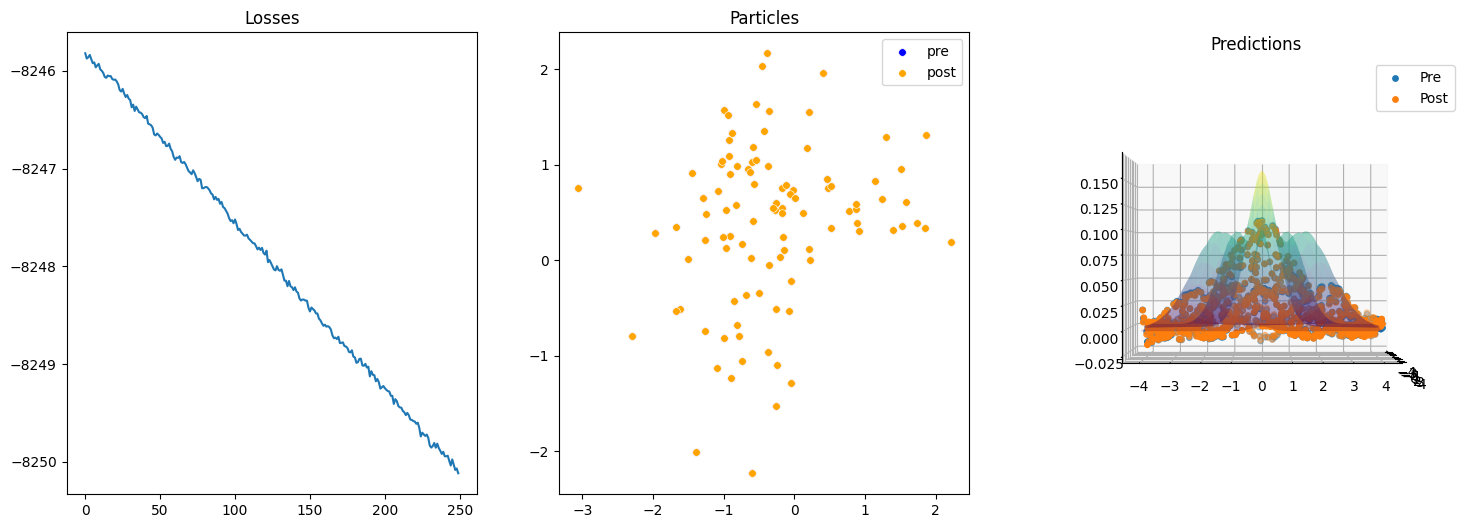

In [43]:
pre_post_plots(
    X_test, orf_losses, orf_gp_pre.kernel.kernel.w, 
    orf_gp.kernel.kernel.w,
    orf_gp_preds_pre, orf_gp_preds, angles=(0,0), s1=30
)

#### Sparse Variational GP

In [45]:
svgp_pre, svgp, svgp_loss = build_train_svgp(key, X_train, y_train, R=100, diag=diag_min, epochs=None)
svgp_loss = jnp.concatenate(
    [jnp.arange(0, len(svgp_loss)).reshape(-1, 1), jnp.array(svgp_loss).reshape(-1, 1)]
, axis=1)

In [47]:
svgp_preds_pre, svgp_pre_sd = svgp_pre.predict_f(np.array(X_test).astype(np.float64))
svgp_preds_pre = jnp.array(svgp_preds_pre).reshape(-1)
svgp_preds, svgp_sd = svgp.predict_f(np.array(X_test).astype(np.float64))
svgp_preds = jnp.array(svgp_preds).reshape(-1)
results(y_test, svgp_preds_pre, svgp_preds)

'MSE Pre: 0.001139; MSE Post: 0.000158'

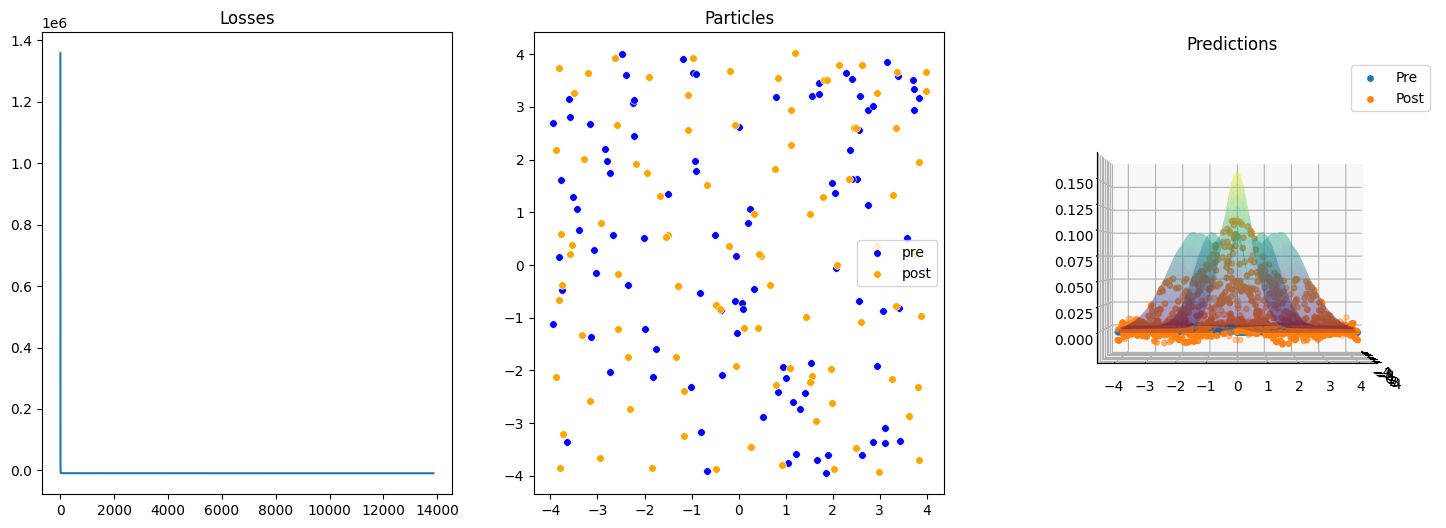

In [51]:
svgd_pre_w = np.array(svgp_pre.inducing_variable.Z)
svgd_w = np.array(svgp.inducing_variable.Z)

pre_post_plots(
    X_test, svgp_loss, svgd_pre_w, svgd_w,
    svgp_preds_pre, svgp_preds, angles=(0,0), s1=30
)

#### RFF GP with RBF

In [ ]:
rff_rbf_params, rff_rbf_hyp_loss = run_hyperopt(
    rff_rbf_cross_val, key, X_train, y_train, n_trials=10, R=100, diag=diag_min
)

In [ ]:
rff_rbf_gp, rff_rbf_gp_pre, rff_rbf_losses = build_train_rff_rbf(key, X_train, y_train, R=100, **rff_rbf_params)

In [ ]:
# evaluate on test
rbf_gp_preds_pre, rff_rbf_sd_pre = rff_rbf_gp_pre.condition(y_train, X_test)
rbf_gp_preds, rff_rbf_sd = rff_rbf_gp.condition(y_train, X_test)
results(y_test, rbf_gp_preds_pre, rbf_gp_preds)

'MSE Pre: 0.000156; MSE Post: 0.000176'

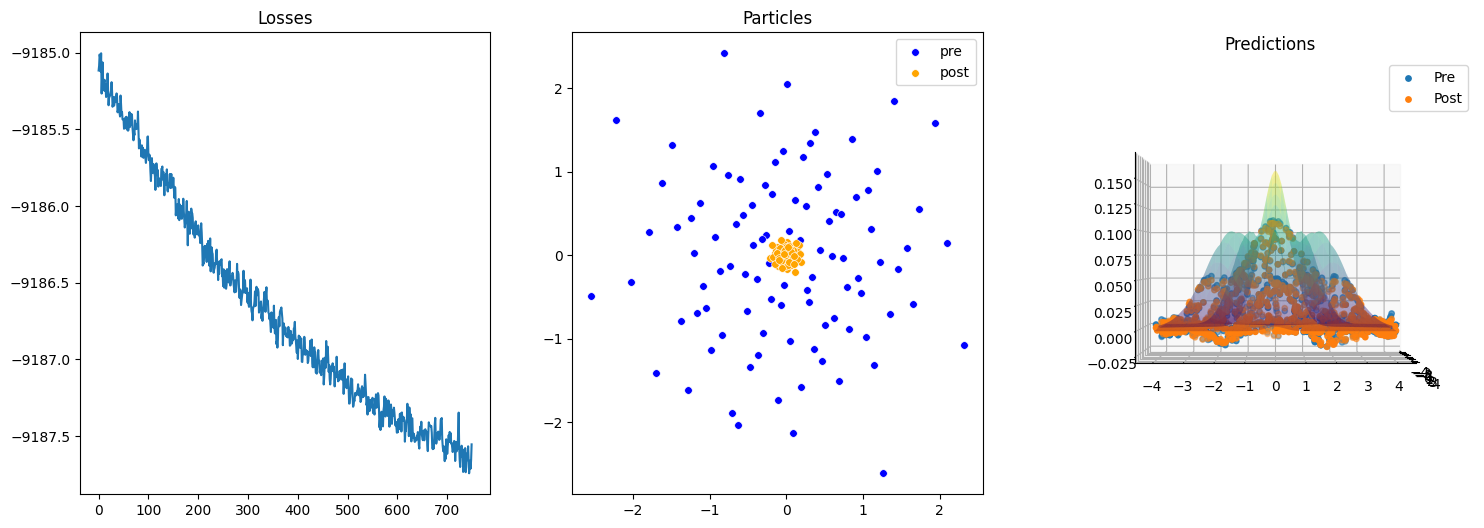

In [64]:
pre_post_plots(
    X_test, rff_rbf_losses, rff_rbf_gp_pre.kernel.kernel.w,
    rff_rbf_gp.kernel.kernel.w * rff_rbf_gp.kernel.scale,
    rbf_gp_preds_pre, rbf_gp_preds, angles=(0,0), s1=30
)

#### Basic RFF GP

In [61]:
rff_params, rff_hyp_loss = run_hyperopt(
    rff_cross_val, key, X_train, y_train, n_trials=10, R=100, epochs=5000
)

[I 2024-01-26 11:14:20,080] A new study created in memory with name: no-name-ab87d97e-f321-418f-81a3-f637c2182f35


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-01-26 11:15:12,994] Trial 0 finished with value: 0.00031173325260169804 and parameters: {'diag': 0.00345271481970197, 'lr': 0.002450646436866301}. Best is trial 0 with value: 0.00031173325260169804.
[I 2024-01-26 11:16:05,066] Trial 1 finished with value: 0.0003815675445366651 and parameters: {'diag': 0.015435233517800602, 'lr': 0.0001190790536702545}. Best is trial 0 with value: 0.00031173325260169804.
[I 2024-01-26 11:16:58,431] Trial 2 finished with value: 0.0002004114503506571 and parameters: {'diag': 0.0012847838483265076, 'lr': 0.017973685009708754}. Best is trial 2 with value: 0.0002004114503506571.
[I 2024-01-26 11:17:51,389] Trial 3 finished with value: 0.00047777657164260745 and parameters: {'diag': 0.05512609435073508, 'lr': 0.0006677790676194685}. Best is trial 2 with value: 0.0002004114503506571.
[I 2024-01-26 11:18:44,549] Trial 4 finished with value: 0.0004466068930923939 and parameters: {'diag': 0.011068857805892602, 'lr': 0.05607363308343791}. Best is trial 2 w

In [66]:
rff_gp, rff_gp_pre, rff_losses = build_train_rff(key, X_train, y_train, R=100, epochs=5000, **rff_params)

# evaluate on test
rff_preds_pre, rff_sd_pre = rff_gp_pre.condition(y_train, X_test)
rff_preds, rff_sd = rff_gp.condition(y_train, X_test)
results(y_test, rff_preds_pre, rff_preds), metric_model(y_test, rff_preds, rff_sd).tolist()

('MSE Pre: 0.000157; MSE Post: 0.000098',
 [9.840265556704253e-05,
  0.0072758812457323074,
  0.8220000267028809,
  0.03986426070332527])

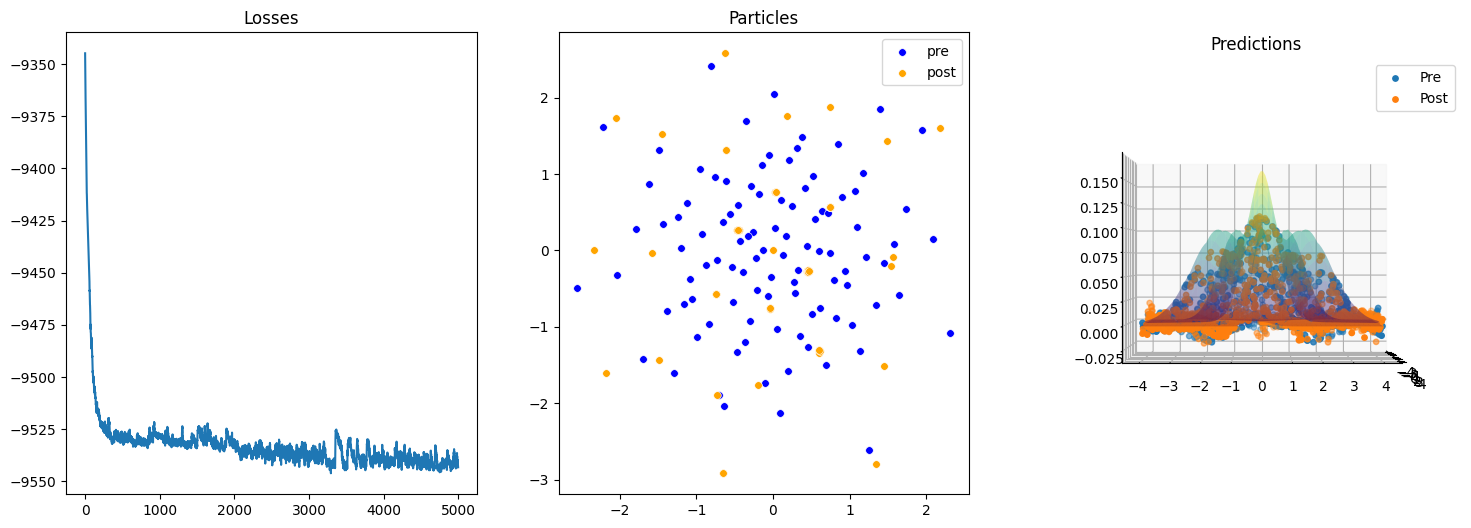

In [64]:
pre_post_plots(
    X_test, rff_losses, rff_gp_pre.kernel.kernel.w, 
    rff_gp.kernel.kernel.w * jnp.exp(rff_gp.kernel.scale),
    rff_preds_pre, rff_preds, angles=(0,0), s1=30
)

<Axes: >

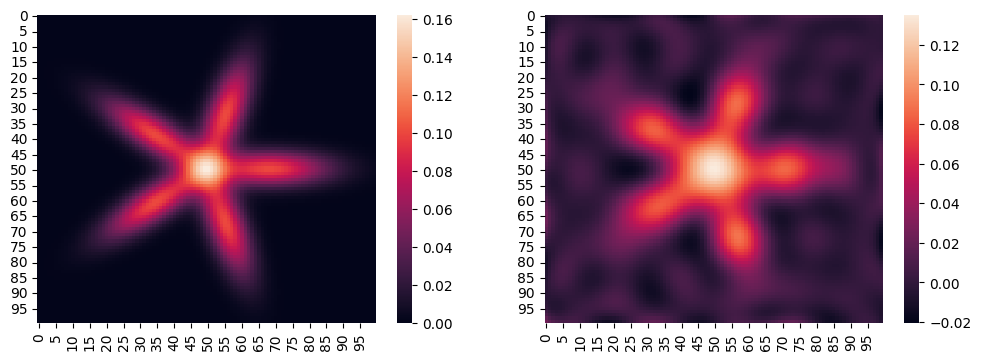

In [23]:
rff_plot_preds = rff_gp.condition(y_train, X_plot.reshape(-1, 2))[0]
rff_plot_preds = rff_plot_preds.reshape(n_per_dim, n_per_dim)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(y_plot, ax=ax[0])
sns.heatmap(rff_plot_preds, ax=ax[1])

<Axes: >

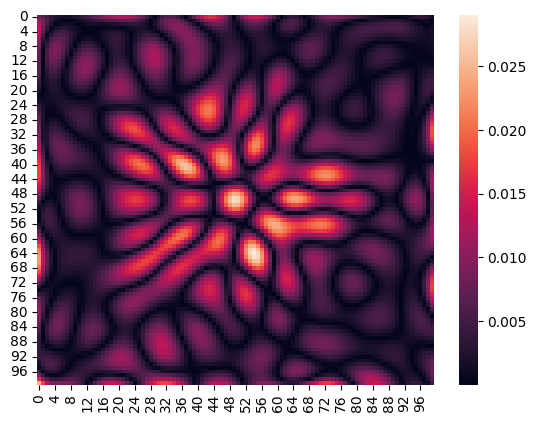

In [24]:
rff_err_plot = jnp.abs(y_plot - rff_plot_preds)
sns.heatmap(rff_err_plot)

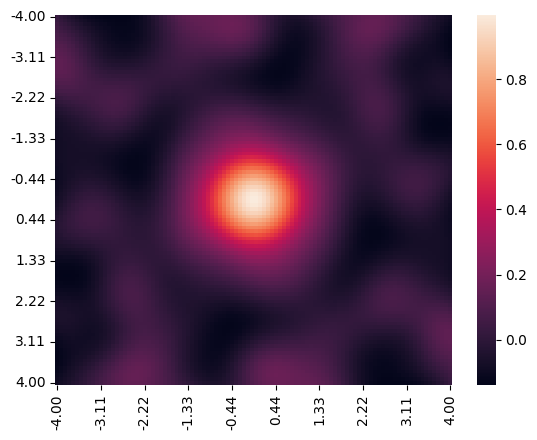

In [25]:
plot_kernel(rff_gp.kernel)

#### SRFR RFF GP

In [39]:
srf_params, srf_hyp_loss = run_hyperopt(
    srf_cross_val, key, X_train, y_train, n_trials=10, R=100, epochs=5000, kernel="m32"
)

[I 2024-01-27 11:57:39,963] A new study created in memory with name: no-name-02301783-8be0-46a1-b6a9-6e964f8f362b


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-01-27 11:58:37,787] Trial 0 finished with value: 0.0002516577369533479 and parameters: {'diag': 0.0014873263738610038, 'lr': 0.00020783932791883228, 'alpha': 0.4106985260013023}. Best is trial 0 with value: 0.0002516577369533479.
[I 2024-01-27 11:59:35,269] Trial 1 finished with value: 0.0003328801249153912 and parameters: {'diag': 0.0022946025666498635, 'lr': 0.000211589524766568, 'alpha': 0.3475125802773997}. Best is trial 0 with value: 0.0002516577369533479.
[I 2024-01-27 12:00:32,749] Trial 2 finished with value: 0.0005965907475911081 and parameters: {'diag': 0.01944168462357252, 'lr': 0.028513160697086204, 'alpha': 0.814856558293417}. Best is trial 0 with value: 0.0002516577369533479.
[I 2024-01-27 12:01:31,202] Trial 3 finished with value: 0.00016870333638507873 and parameters: {'diag': 0.00038978078766488817, 'lr': 0.0001453702922937253, 'alpha': 0.21455744516087027}. Best is trial 3 with value: 0.00016870333638507873.
[I 2024-01-27 12:02:28,333] Trial 4 finished with va

In [43]:
srf_params

{'diag': 0.00038978078766488817,
 'lr': 0.0001453702922937253,
 'alpha': 0.21455744516087027}

In [42]:
srf_gp, srf_gp_pre, srf_losses = build_train_srf(
    key, X_train, y_train, R=100, epochs=5000, kernel="m32", **srf_params
)

# evaluate on test
srf_preds_pre, srf_sd_pre = srf_gp_pre.condition(y_train, X_test)
srf_preds, srf_sd = srf_gp.condition(y_train, X_test)
results(y_test, srf_preds_pre, srf_preds), metric_model(y_test, srf_preds, srf_sd).tolist()

('MSE Pre: 0.000151; MSE Post: 0.000063',
 [6.275055056903511e-05, 0.005854486022144556, 0.7950000166893005, nan])

In [ ]:
# M32
# ('MSE Pre: 0.000151; MSE Post: 0.000063',
#  [6.275055056903511e-05, 0.005854486022144556, 0.7950000166893005, nan])

# RBF
# ('MSE Pre: 0.000151; MSE Post: 0.000046',
#  [4.569395969156176e-05, 0.005079040769487619, 0.8520000576972961, nan])

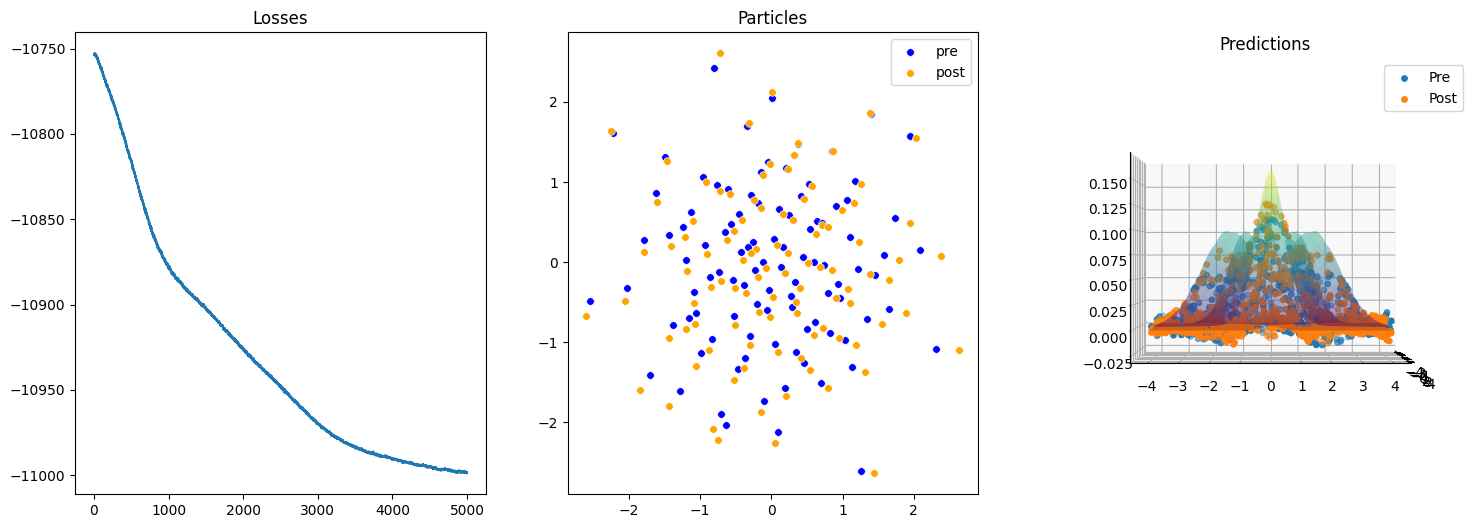

In [45]:
pre_post_plots(
    X_test, srf_losses, srf_gp_pre.kernel.kernel.w, 
    srf_gp.kernel.kernel.w, * jnp.exp(srf_gp.kernel.scale),
    srf_preds_pre, srf_preds, angles=(0,0), s1=30
)

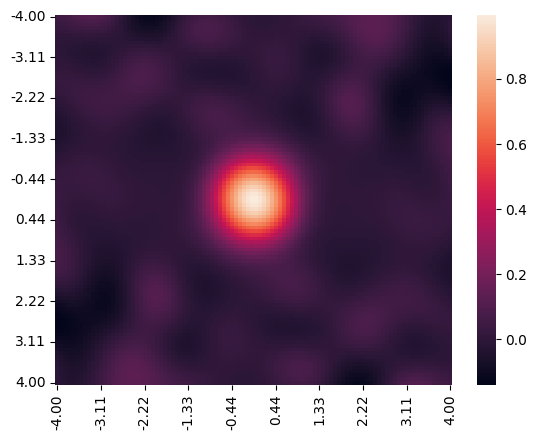

In [31]:
plot_kernel(srf_gp.kernel)

In [520]:
srf_preds, srf_sd = srf_gp.condition(y_train, X_plot.reshape(-1, 2))
srf_preds = srf_preds.reshape(n_per_dim, n_per_dim)

<Axes: >

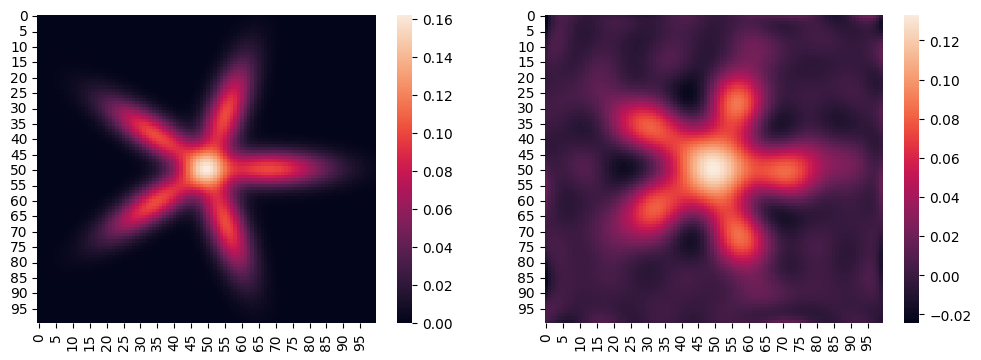

In [521]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(y_plot, ax=ax[0])
sns.heatmap(srf_preds, ax=ax[1])

<Axes: >

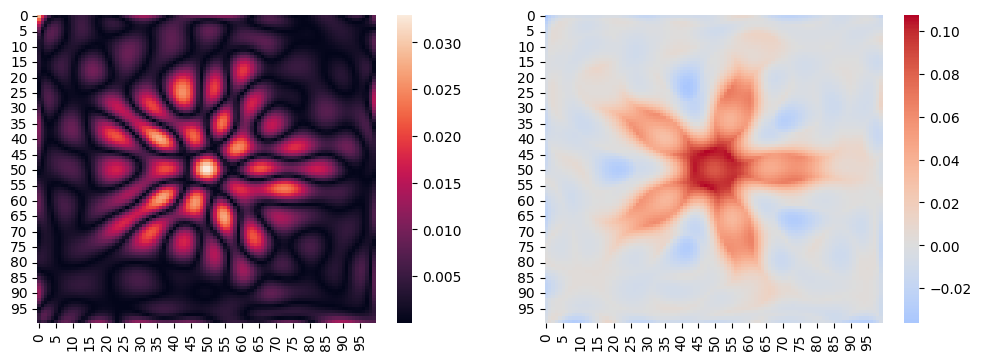

In [504]:
new_err = jnp.abs(srf_preds - y_plot)
err_diff = srf_preds - srf_og_err

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(new_err, ax=ax[0])
sns.heatmap(err_diff, ax=ax[1], cmap='coolwarm', center=0)

<Axes: >

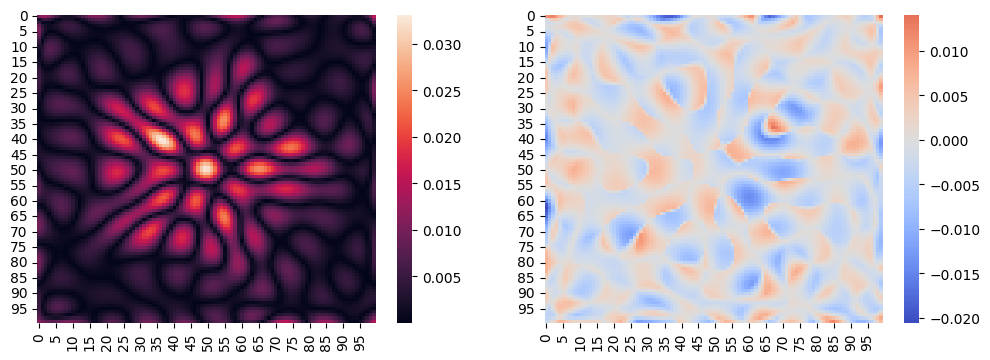

In [366]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(new_err, ax=ax[0])
sns.heatmap(new_err - rff_err_plot, ax=ax[1], cmap='coolwarm', center=0)

<Axes: >

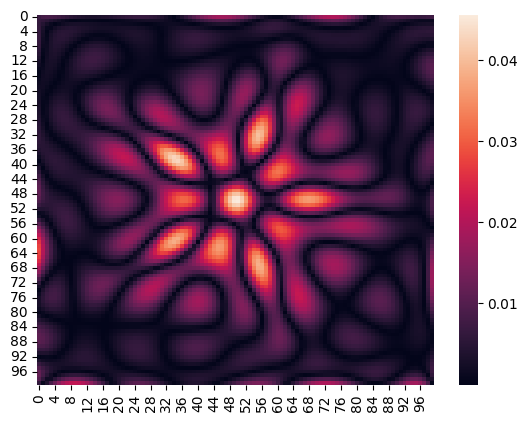

In [332]:
srf_preds_og, srf_sd = srf_gp.condition(y_train, X_plot.reshape(-1, 2))
srf_preds_og = srf_preds_og.reshape(n_per_dim, n_per_dim)
srf_og_err = jnp.abs(srf_preds_og - y_plot)
sns.heatmap(srf_og_err)

#### Matrix SRFR GP

In [34]:
msrf_params, msrf_hyp_loss = run_hyperopt(
    msrf_cross_val, key, X_train, y_train, n_trials=10, R=100, epochs=5000
)
# msrf_params["diag"] += 1e-4

[I 2024-01-26 10:54:06,025] A new study created in memory with name: no-name-803fc199-27e6-43a3-9dab-7ce11d5e8ad3


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-01-26 10:55:10,464] Trial 0 finished with value: 0.0005708974786102772 and parameters: {'diag': 0.045006932623029995, 'lr': 0.0037587836533957016, 'alpha': 0.8904897590657155}. Best is trial 0 with value: 0.0005708974786102772.
[I 2024-01-26 10:56:14,242] Trial 1 finished with value: 0.0004554706974886358 and parameters: {'diag': 0.008624760754810983, 'lr': 0.0007920579487350368, 'alpha': 0.13261934726296892}. Best is trial 1 with value: 0.0004554706974886358.
[I 2024-01-26 10:57:16,596] Trial 2 finished with value: 0.00043485555215738714 and parameters: {'diag': 0.0337709664786166, 'lr': 0.0002554628126771047, 'alpha': 0.1546350868059532}. Best is trial 2 with value: 0.00043485555215738714.
[I 2024-01-26 10:58:17,781] Trial 3 finished with value: 0.0002657517325133085 and parameters: {'diag': 0.0006776099109819383, 'lr': 0.02509698073660946, 'alpha': 0.9068710251305433}. Best is trial 3 with value: 0.0002657517325133085.
[I 2024-01-26 10:59:16,600] Trial 4 finished with value:

In [70]:
msrf_gp, msrf_gp_pre, msrf_losses = build_train_msrf(
    key, X_train, y_train, R=100, epochs=5000, **msrf_params
)

# evaluate on test
msrf_preds_pre, msrf_sd_pre = msrf_gp_pre.condition(y_train, X_test)
msrf_preds, msrf_sd = msrf_gp.condition(y_train, X_test)
results(y_test, msrf_preds_pre, msrf_preds), metric_model(y_test, msrf_preds, msrf_sd).tolist()

('MSE Pre: 0.000152; MSE Post: 0.000046',
 [4.649012771551497e-05, 0.0050395941361784935, 0.8710000514984131, nan])

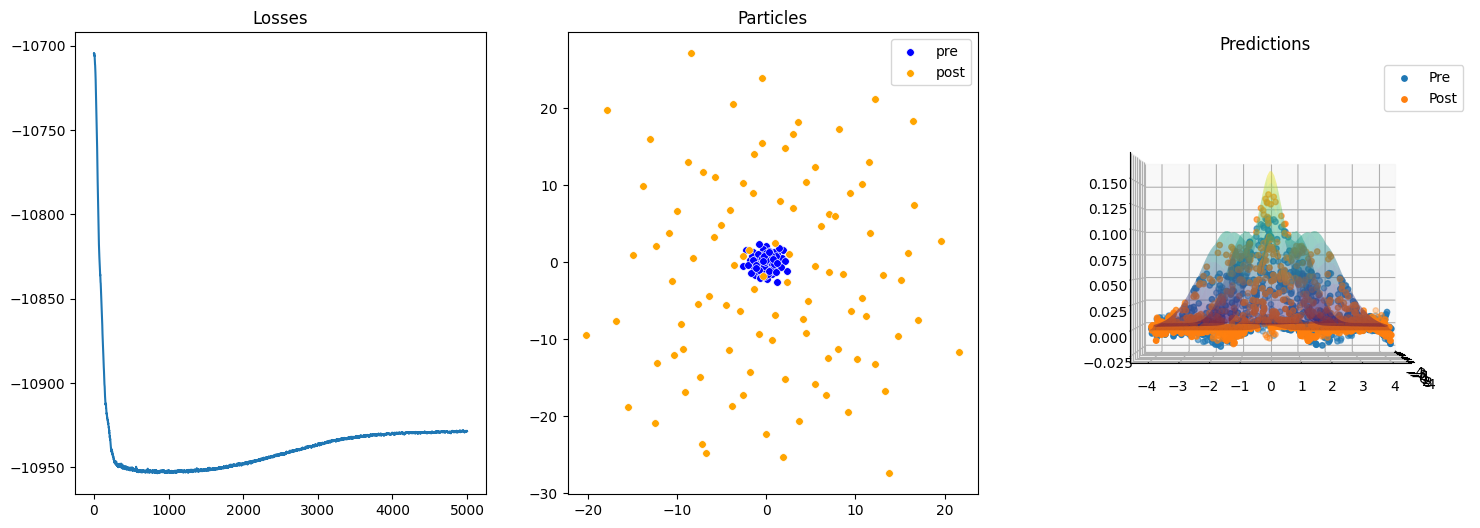

In [55]:
pre_post_plots(
    X_test, msrf_losses, msrf_gp_pre.kernel.kernel.w, 
    msrf_gp.kernel.kernel.w * jnp.exp(msrf_gp.kernel.scale),
    msrf_preds_pre, msrf_preds, angles=(0,0), s1=30
)

#### Nonstationary GP

In [85]:
nrff_params, nrff_hyp_loss = run_hyperopt(
    nrff_cross_val, key, X_train, y_train, n_trials=10, R=100, epochs=5000
)

[I 2024-01-17 15:40:59,373] A new study created in memory with name: no-name-1a93a568-3a15-4181-9d63-ea45e52a048a
[I 2024-01-17 15:41:04,710] Trial 0 finished with value: 0.0003461039741523564 and parameters: {'diag': 0.07077310252483976, 'epochs': 250, 'learning_rate': 0.061506038097970867}. Best is trial 0 with value: 0.0003461039741523564.
[I 2024-01-17 15:41:14,738] Trial 1 finished with value: 0.00010302577720722184 and parameters: {'diag': 0.0013355631064405139, 'epochs': 750, 'learning_rate': 0.0011721844487260088}. Best is trial 1 with value: 0.00010302577720722184.
[I 2024-01-17 15:41:27,405] Trial 2 finished with value: 0.00019055130542255938 and parameters: {'diag': 0.011563097932081079, 'epochs': 1000, 'learning_rate': 0.004190585530758805}. Best is trial 1 with value: 0.00010302577720722184.
[I 2024-01-17 15:41:39,890] Trial 3 finished with value: 0.00015945234918035567 and parameters: {'diag': 0.0036171963524918725, 'epochs': 1000, 'learning_rate': 0.05176717984236957}. B

In [ ]:
nrff_gp, nrff_gp_pre, nrff_losses = build_train_nrff(
    key, X_train, y_train, R=100, epochs=5000, **nrff_params
)

In [86]:
# evaluate on test
nrff_preds_pre, nrff_sd_pre = nrff_gp_pre.condition(y_train, X_test)
nrff_preds, nrff_sd = nrff_gp.condition(y_train, X_test)
results(y_test, nrff_preds_pre, nrff_preds), metric_model(y_test, nrff_preds, nrff_sd).tolist()

'MSE Pre: 0.000148; MSE Post: 0.000097'

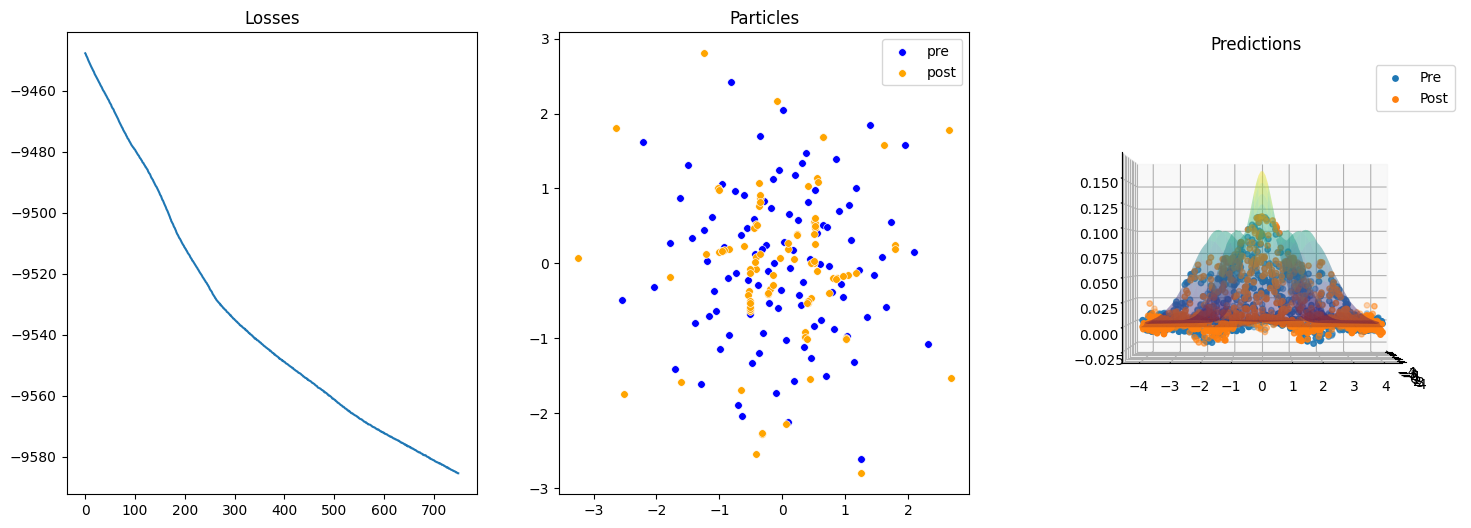

In [87]:
pre_post_plots(
    X_test, nrff_losses, nrff_gp_pre.kernel.kernel.w, 
    nrff_gp.kernel.kernel.w * jnp.exp(nrff_gp.kernel.scale),
    nrff_preds_pre, nrff_preds, angles=(0,0), s1=30
)

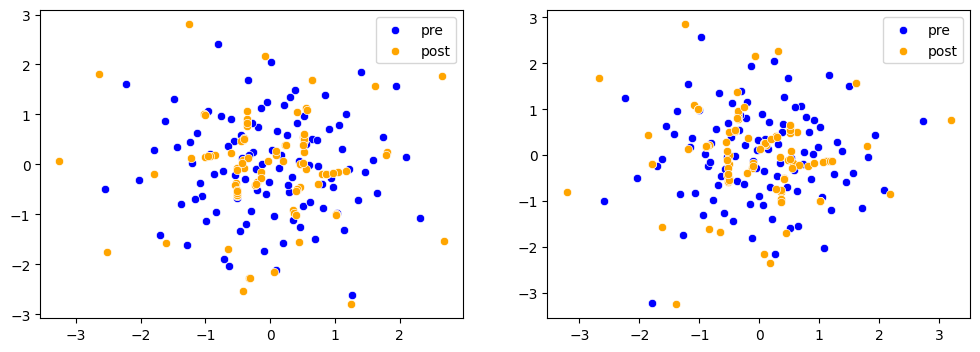

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x=nrff_gp_pre.kernel.kernel.w[:,0], y=nrff_gp_pre.kernel.kernel.w[:,1], ax=ax[0], label='pre', color='blue')
sns.scatterplot(x=nrff_gp.kernel.kernel.w[:,0], y=nrff_gp.kernel.kernel.w[:,1], ax=ax[0], label='post', color='orange')
sns.scatterplot(x=nrff_gp_pre.kernel.kernel.w[:,2], y=nrff_gp_pre.kernel.kernel.w[:,3], ax=ax[1], label='pre', color='blue')
sns.scatterplot(x=nrff_gp.kernel.kernel.w[:,2], y=nrff_gp.kernel.kernel.w[:,3], ax=ax[1], label='post', color='orange')
plt.show()

#### Nonstationary SVGD GP

In [111]:
nsrf_params, nsrf_hyp_loss = run_hyperopt(
    nsrf_cross_val, key, X_train, y_train, n_trials=10, R=100, epochs=5000
)

[I 2024-01-23 13:09:17,793] A new study created in memory with name: no-name-07d2ca2d-555a-40a9-b816-c277682a870d


[I 2024-01-23 13:09:33,062] Trial 0 finished with value: 9.811137715587392e-05 and parameters: {'epochs': 500, 'learning_rate': 0.027594485202140133, 'alpha': 0.49075897587342376}. Best is trial 0 with value: 9.811137715587392e-05.
[I 2024-01-23 13:09:50,080] Trial 1 finished with value: 9.971845429390669e-05 and parameters: {'epochs': 1000, 'learning_rate': 0.020829738479495676, 'alpha': 3.3454205002311106}. Best is trial 0 with value: 9.811137715587392e-05.
[I 2024-01-23 13:10:06,389] Trial 2 finished with value: 0.00010921854118350893 and parameters: {'epochs': 1000, 'learning_rate': 0.0008882999875873658, 'alpha': 3.047773911386255}. Best is trial 0 with value: 9.811137715587392e-05.
[I 2024-01-23 13:10:20,722] Trial 3 finished with value: 0.00012751838949043304 and parameters: {'epochs': 750, 'learning_rate': 0.00010616617983171778, 'alpha': 3.433642828008326}. Best is trial 0 with value: 9.811137715587392e-05.
[I 2024-01-23 13:10:29,900] Trial 4 finished with value: 0.00012853198

In [112]:
nsrf_gp, nsrf_gp_pre, nsrf_losses = build_train_nsrf(
    key, X_train, y_train, R=100, epochs=5000, **nsrf_params
)

# evaluate on test
nsrf_preds_pre, nsrf_sd_pre = nsrf_gp_pre.condition(y_train, X_test)
nsrf_preds, nsrf_sd = nsrf_gp.condition(y_train, X_test)
results(y_test, nsrf_preds_pre, nsrf_preds), metric_model(y_test, nsrf_preds, nsrf_sd).tolist()


'MSE Pre: 0.000146; MSE Post: 0.000108'

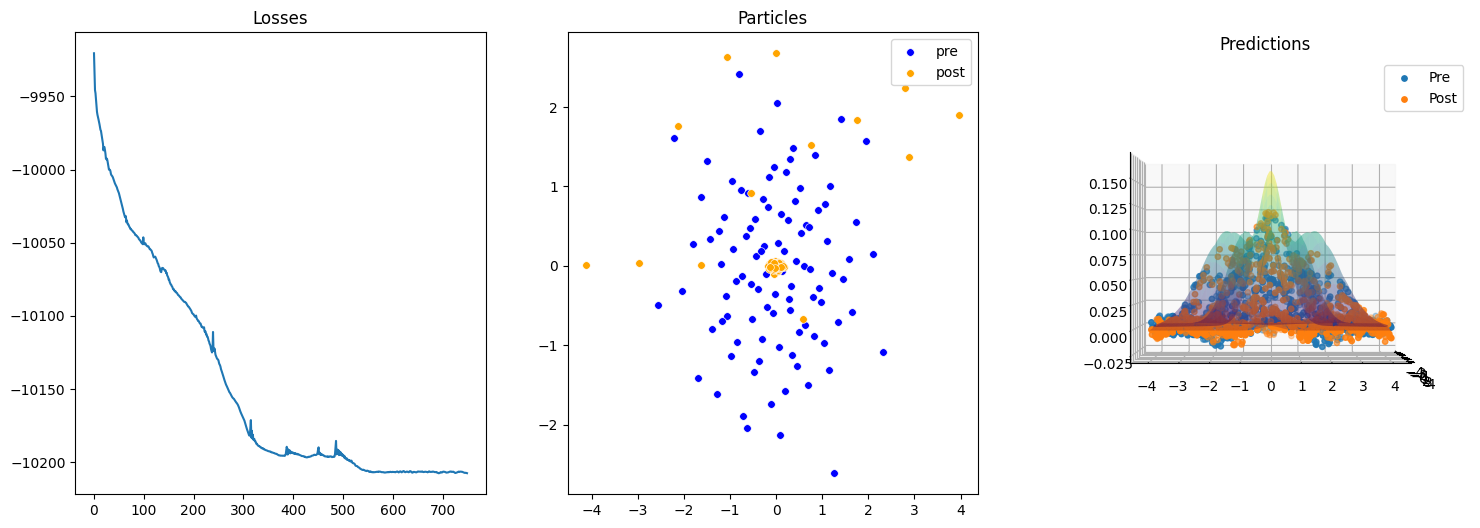

In [257]:
pre_post_plots(
    X_test, nsrf_losses, nsrf_gp_pre.kernel.kernel.w, 
    nsrf_gp.kernel.kernel.w * jnp.exp(nsrf_gp.kernel.scale),
    nsrf_preds_pre, nsrf_preds, angles=(0,0), s1=30
)

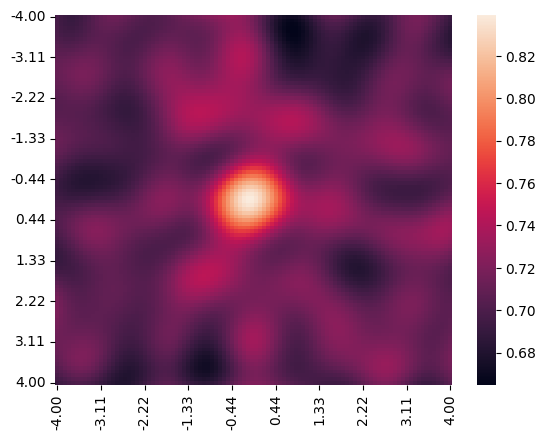

In [261]:
plot_kernel(nsrf_gp.kernel)

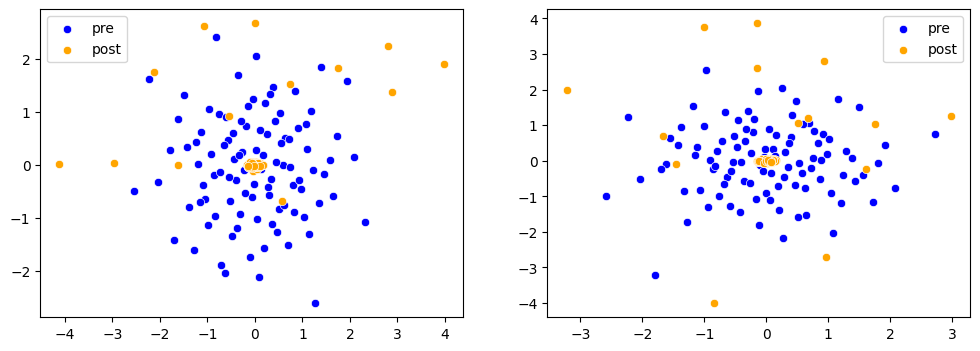

In [258]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x=nsrf_gp_pre.kernel.kernel.w[:,0], y=nsrf_gp_pre.kernel.kernel.w[:,1], ax=ax[0], label='pre', color='blue')
sns.scatterplot(x=nsrf_gp.kernel.kernel.w[:,0], y=nsrf_gp.kernel.kernel.w[:,1], ax=ax[0], label='post', color='orange')
sns.scatterplot(x=nsrf_gp_pre.kernel.kernel.w[:,2], y=nsrf_gp_pre.kernel.kernel.w[:,3], ax=ax[1], label='pre', color='blue')
sns.scatterplot(x=nsrf_gp.kernel.kernel.w[:,2], y=nsrf_gp.kernel.kernel.w[:,3], ax=ax[1], label='post', color='orange')
plt.show()

#### Nonstationary Matrix-SVGD GP

In [ ]:
nmsrf_params, nmsrf_hyp_loss = run_hyperopt(
    nmsrf_cross_val, key, X_train, y_train, n_trials=10, R=100, epochs=5000
)

In [ ]:
nmsrf_gp, nmsrf_gp_pre, nmsrf_losses = build_train_nmsrf(
    key, X_train, y_train, R=100, epochs=5000, **nmsrf_params
)

# evaluate on test
nmsrf_preds_pre, nmsrf_sd_pre = nmsrf_gp_pre.condition(y_train, X_test)
nmsrf_preds, nmsrf_sd = nmsrf_gp.condition(y_train, X_test)
results(y_test, nmsrf_preds_pre, nmsrf_preds), metric_model(y_test, nmsrf_preds, nmsrf_sd).tolist()


In [ ]:
pre_post_plots(
    X_test, nmsrf_losses, nmsrf_gp_pre.kernel.kernel.w, 
    nmsrf_gp.kernel.kernel.w * jnp.exp(nmsrf_gp.kernel.scale),
    nmsrf_preds_pre, nmsrf_preds, angles=(0,0), s1=30
)

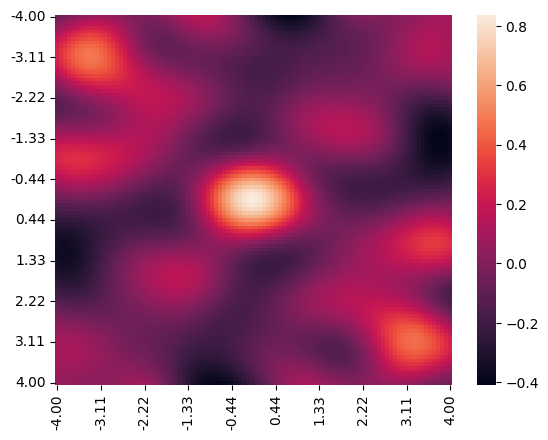

In [45]:
plot_kernel(nmsrf_gp.kernel)

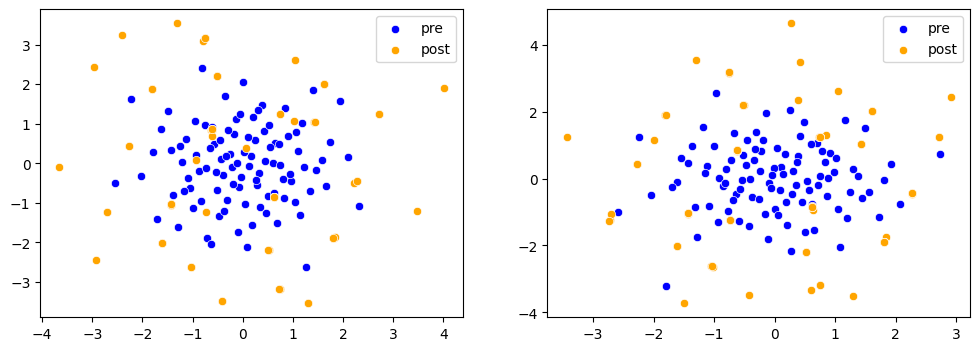

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x=nmsrf_gp_pre.kernel.kernel.w[:,0], y=nmsrf_gp_pre.kernel.kernel.w[:,1], ax=ax[0], label='pre', color='blue')
sns.scatterplot(x=nmsrf_gp.kernel.kernel.w[:,0], y=nmsrf_gp.kernel.kernel.w[:,1], ax=ax[0], label='post', color='orange')
sns.scatterplot(x=nmsrf_gp_pre.kernel.kernel.w[:,2], y=nmsrf_gp_pre.kernel.kernel.w[:,3], ax=ax[1], label='pre', color='blue')
sns.scatterplot(x=nmsrf_gp.kernel.kernel.w[:,2], y=nmsrf_gp.kernel.kernel.w[:,3], ax=ax[1], label='post', color='orange')
plt.show()

#### Deep Kernel GP

In [74]:
dk_params, dk_hyp_loss = run_hyperopt(
    dk_cross_val, key, X_train, y_train, n_trials=10, R=100, epochs=5000, d_nn=d_nn
)

[I 2024-01-26 11:34:37,118] A new study created in memory with name: no-name-25390b75-668f-4fa7-ba1e-89806058cfe5


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2024-01-26 11:35:36,277] Trial 0 failed with parameters: {'diag': 0.0003085923191789201, 'lr': 0.0014968971923326805} because of the following error: The value nan is not acceptable.
[W 2024-01-26 11:35:36,278] Trial 0 failed with value nan.
[I 2024-01-26 11:36:34,372] Trial 1 finished with value: 0.00011344470840413123 and parameters: {'diag': 0.011007827900069109, 'lr': 0.03283721557541991}. Best is trial 1 with value: 0.00011344470840413123.
[I 2024-01-26 11:37:33,830] Trial 2 finished with value: 0.00011557029938558117 and parameters: {'diag': 0.014822616887145538, 'lr': 0.00018701604282580518}. Best is trial 1 with value: 0.00011344470840413123.
[I 2024-01-26 11:38:33,908] Trial 3 finished with value: 0.0005674613057635725 and parameters: {'diag': 0.04766069595375849, 'lr': 0.06294656712368392}. Best is trial 1 with value: 0.00011344470840413123.
[W 2024-01-26 11:39:32,791] Trial 4 failed with parameters: {'diag': 0.0006848040359200338, 'lr': 0.0010797886680846765} because of t

In [75]:
dk_gp, dk_gp_pre, dk_losses = build_train_dk(
    key, X_train, y_train, R=100, epochs=5000, d_nn=d_nn, **dk_params
)

# evaluate on test
dk_preds_pre, dk_sd_pre = dk_gp_pre.condition(y_train, X_test)
dk_preds, dk_sd = dk_gp.condition(y_train, X_test)
results(y_test, dk_preds_pre, dk_preds), metric_model(y_test, dk_preds, dk_sd).tolist()

('MSE Pre: 0.000464; MSE Post: 0.000012',
 [1.196980883833021e-05, 0.002602614928036928, 0.9040000438690186, nan])

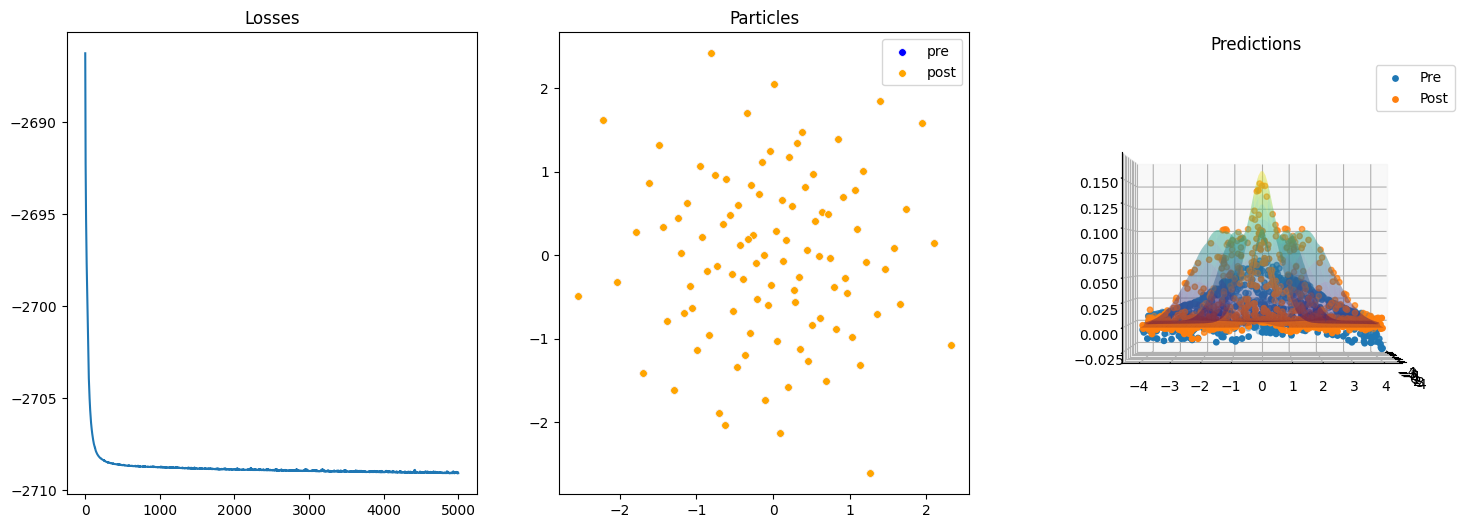

In [77]:
pre_post_plots(
    X_test, dk_losses, dk_gp_pre.kernel.kernel.w, 
    dk_gp.kernel.kernel.w,
    dk_preds_pre, dk_preds, angles=(0,0), s1=30
)

#### Deep Kernel SRFR GP

In [79]:
sdk_params, sdk_hyp_loss = run_hyperopt(
    sdk_cross_val, key, X_train, y_train, n_trials=10, R=100, d_nn=d_nn, epochs=5000
)

[I 2024-01-26 11:47:08,189] A new study created in memory with name: no-name-5bf461a2-77e5-4d01-922a-3a67443ae36e


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-01-26 11:48:14,360] Trial 0 finished with value: 0.00011318664473947138 and parameters: {'diag': 0.05601642582298332, 'lr': 0.0002727196205301637, 'alpha': 0.34387477666096833}. Best is trial 0 with value: 0.00011318664473947138.
[I 2024-01-26 11:49:21,060] Trial 1 finished with value: 0.00013452100392896682 and parameters: {'diag': 0.00540839570957946, 'lr': 0.002320095215197972, 'alpha': 0.4603198781204254}. Best is trial 0 with value: 0.00011318664473947138.
[I 2024-01-26 11:50:26,644] Trial 2 finished with value: 0.00024902733275666833 and parameters: {'diag': 0.020207284083047283, 'lr': 0.03165834805195307, 'alpha': 0.5580034686193844}. Best is trial 0 with value: 0.00011318664473947138.
[I 2024-01-26 11:51:32,805] Trial 3 finished with value: 0.00011452615581220016 and parameters: {'diag': 0.08058550772588081, 'lr': 0.0004851955926551695, 'alpha': 0.5741282000555414}. Best is trial 0 with value: 0.00011318664473947138.
[W 2024-01-26 11:52:41,476] Trial 4 failed with param

In [80]:
sdk_gp, sdk_gp_pre, sdk_losses = build_train_sdk(
    key, X_train, y_train, R=100, epochs=5000, d_nn=d_nn, **sdk_params
)

# evaluate on test
sdk_preds_pre, sdk_sd_pre = sdk_gp_pre.condition(y_train, X_test)
sdk_preds, sdk_sd = sdk_gp.condition(y_train, X_test)
results(y_test, sdk_preds_pre, sdk_preds), metric_model(y_test, sdk_preds, sdk_sd).tolist()

('MSE Pre: 0.000462; MSE Post: 0.000009',
 [9.243919521395583e-06, 0.002363888779655099, 0.9230000376701355, nan])

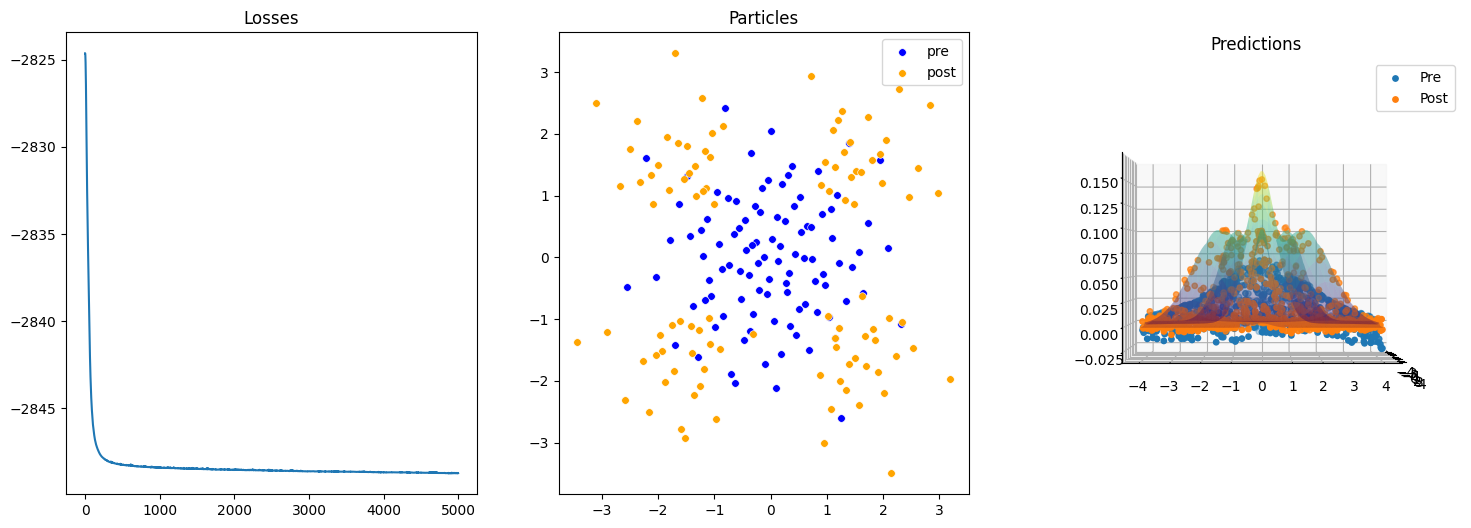

In [81]:
pre_post_plots(
    X_test, sdk_losses, sdk_gp_pre.kernel.kernel.w, 
    sdk_gp.kernel.kernel.w,
    sdk_preds_pre, sdk_preds, angles=(0,0), s1=30
)

#### Deep Matrix SRFR GP

In [ ]:
msdk_params, msdk_hyp_loss = run_hyperopt(
    msdk_cross_val, key, X_train, y_train, n_trials=10, R=100, d_nn=d_nn, epochs=5000
)

In [ ]:
msdk_gp, msdk_gp_pre, msdk_losses = build_train_msdk(
    key, X_train, y_train, R=100, epochs=5000, d_nn=d_nn, **msdk_params
)

# evaluate on test
msdk_preds_pre, msdk_sd_pre = msdk_gp_pre.condition(y_train, X_test)
msdk_preds, msdk_sd = msdk_gp.condition(y_train, X_test)
results(y_test, msdk_preds_pre, msdk_preds), metric_model(y_test, msdk_preds, msdk_sd).tolist()

In [ ]:
pre_post_plots(
    X_test, msdk_losses, msdk_gp_pre.kernel.kernel.w, 
    msdk_gp.kernel.kernel.w * jnp.exp(msdk_gp.kernel.scale),
    msdk_preds_pre, msdk_preds, angles=(0,0), s1=30
)

#### Deep RFF

In [86]:
drff_params, drff_hyp_loss = run_hyperopt(
    drff_cross_val, key, X_train, y_train, n_trials=10, R=100, d_nn=d_nn_rff, epochs=5000
)

[I 2024-01-26 12:10:14,204] A new study created in memory with name: no-name-12ae2a80-f5b9-41b8-aa6d-337783f23069


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-01-26 12:11:14,104] Trial 0 finished with value: 0.0003348207683302462 and parameters: {'diag': 0.05770959573423816, 'lr': 0.028516345705188677}. Best is trial 0 with value: 0.0003348207683302462.
[W 2024-01-26 12:12:14,092] Trial 1 failed with parameters: {'diag': 0.0005344765787241695, 'lr': 0.060732639450370156} because of the following error: The value nan is not acceptable.
[W 2024-01-26 12:12:14,093] Trial 1 failed with value nan.
[I 2024-01-26 12:13:12,517] Trial 2 finished with value: 0.0001164445056929253 and parameters: {'diag': 0.010216902101632013, 'lr': 0.004828903743755661}. Best is trial 2 with value: 0.0001164445056929253.
[I 2024-01-26 12:14:13,166] Trial 3 finished with value: 0.0003747106238733977 and parameters: {'diag': 0.023388896596743994, 'lr': 0.0513879964972489}. Best is trial 2 with value: 0.0001164445056929253.
[I 2024-01-26 12:15:13,617] Trial 4 finished with value: 0.0001202259081765078 and parameters: {'diag': 0.055610813859351974, 'lr': 0.0042949

In [87]:
drff_gp, drff_gp_pre, drff_losses = build_train_drff(
    key, X_train, y_train, R=100, epochs=5000, d_nn=d_nn_rff, **drff_params
)

# evaluate on test
drff_preds_pre, drff_sd_pre = drff_gp_pre.condition(y_train, X_test)
drff_preds, drff_sd = drff_gp.condition(y_train, X_test)
results(y_test, drff_preds_pre, drff_preds), metric_model(y_test, drff_preds, drff_sd).tolist()

('MSE Pre: 0.000876; MSE Post: 0.000007',
 [6.9860984694969375e-06, 0.0019792786333709955, 1.0, -0.006077875848859549])

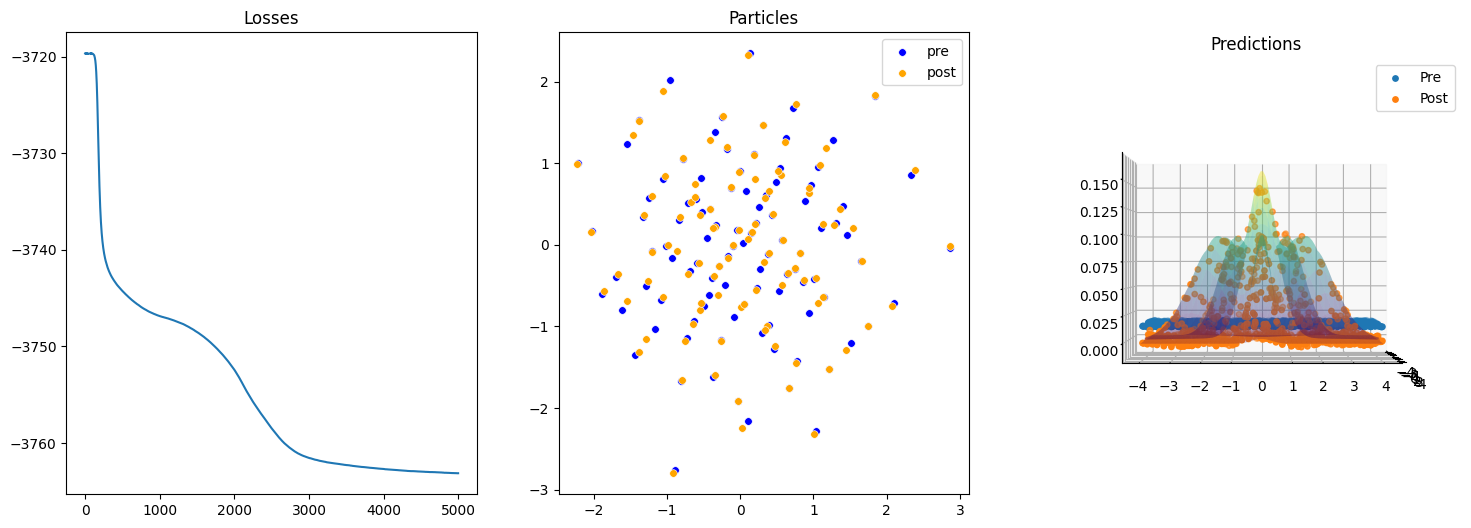

In [88]:
pre_post_plots(
    X_test, drff_losses, drff_gp_pre.kernel.kernel.w, 
    drff_gp.kernel.kernel.w,
    drff_preds_pre, drff_preds, angles=(0,0), s1=30
)

#### Deep SRFR RFF

In [ ]:
dsrf_params, dsrf_hyp_loss = run_hyperopt(
    dsrf_cross_val, key, X_train, y_train, n_trials=10, R=100, d_nn=d_nn_rff, epochs=5000
)

In [ ]:
dsrf_gp, dsrf_gp_pre, dsrf_losses = build_train_dsrf(
    key, X_train, y_train, R=100, epochs=5000, d_nn=d_nn_rff, **dsrf_params
)

# evaluate on test
dsrf_preds_pre, dsrf_sd_pre = dsrf_gp_pre.condition(y_train, X_test)
dsrf_preds, dsrf_sd = dsrf_gp.condition(y_train, X_test)
results(y_test, dsrf_preds_pre, dsrf_preds), metric_model(y_test, dsrf_preds, dsrf_sd).tolist()

In [ ]:
pre_post_plots(
    X_test, dsrf_losses, dsrf_gp_pre.kernel.kernel.w, 
    dsrf_gp.kernel.kernel.w,
    dsrf_preds_pre, dsrf_preds, angles=(0,0), s1=30
)

#### Deep Matrix SRF

In [89]:
dmsrf_params, dmsrf_hyp_loss = run_hyperopt(
    dmsrf_cross_val, key, X_train, y_train, n_trials=10, R=100, d_nn=d_nn_rff, epochs=5000
)

[I 2024-01-26 12:21:15,335] A new study created in memory with name: no-name-3d9bfdb9-0233-4b24-8355-689610583101


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2024-01-26 12:23:30,463] Trial 0 failed with parameters: {'diag': 0.0013292036105627006, 'lr': 0.000327658291219799, 'alpha': 0.5335930382821116} because of the following error: The value nan is not acceptable.
[W 2024-01-26 12:23:30,464] Trial 0 failed with value nan.
[W 2024-01-26 12:25:44,392] Trial 1 failed with parameters: {'diag': 0.002148812960182183, 'lr': 0.006160395263615517, 'alpha': 0.4691248752187838} because of the following error: The value nan is not acceptable.
[W 2024-01-26 12:25:44,393] Trial 1 failed with value nan.
[I 2024-01-26 12:28:01,866] Trial 2 finished with value: 0.0008642307366244495 and parameters: {'diag': 0.009133574119656086, 'lr': 0.00018855998982980954, 'alpha': 0.6878353260113219}. Best is trial 2 with value: 0.0008642307366244495.
[I 2024-01-26 12:30:18,325] Trial 3 finished with value: 0.0002166322956327349 and parameters: {'diag': 0.007385923497561837, 'lr': 0.005443557619304192, 'alpha': 0.30736770025079857}. Best is trial 3 with value: 0.000

In [102]:
dmsrf_gp, dmsrf_gp_pre, dmsrf_losses = build_train_dmsrf(
    key, X_train, y_train, R=100, epochs=10000, d_nn=d_nn_rff, diag=0.01, alpha=0.07, lr=0.01
)

# evaluate on test
dmsrf_preds_pre, dmsrf_sd_pre = dmsrf_gp_pre.condition(y_train, X_test)
dmsrf_preds, dmsrf_sd = dmsrf_gp.condition(y_train, X_test)
results(y_test, dmsrf_preds_pre, dmsrf_preds), metric_model(y_test, dmsrf_preds, dmsrf_sd).tolist()

('MSE Pre: 0.000875; MSE Post: 0.000258',
 [0.0002578354033175856, 0.010027888230979443, 0.8700000643730164, nan])

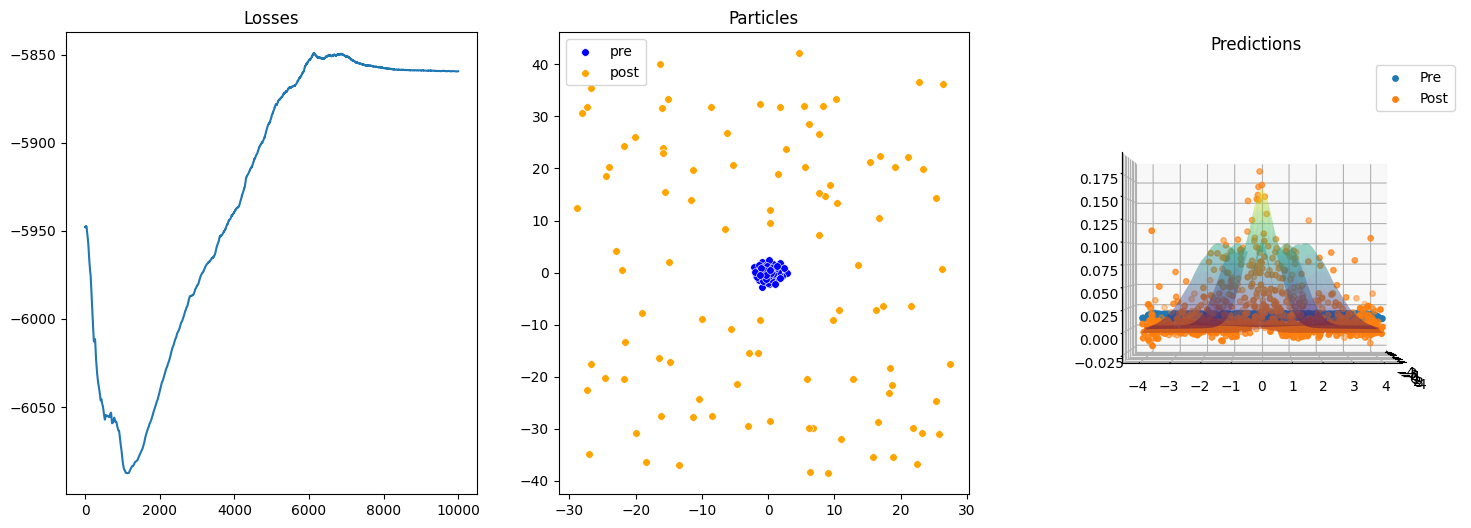

In [103]:
pre_post_plots(
    X_test, dmsrf_losses, dmsrf_gp_pre.kernel.kernel.w, 
    dmsrf_gp.kernel.kernel.w,
    dmsrf_preds_pre, dmsrf_preds, angles=(0,0), s1=30
)

## Joint Run

In [ ]:
def run_experiment(key, N, R, opt=False, **kwargs):
    
    #### create data
    env = star_gaussian(10, 5)
    bound = 4
    X = jax.random.uniform(
        key, shape = (N, 2), minval=jnp.array([-bound, -bound]), maxval=jnp.array([bound, bound])
    )
    y = jnp.exp(env.logp(X))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #### build and train each model
    n_trials = kwargs.get('n_trials', 10)
    res = []

    ## RBF-RFF
    rff_rbf_params = kwargs.get('rff_rbf_params', None)
    if rff_rbf_params is None and opt:
        print('Optimizing RFF-RBF')
        _, _, _, rff_rbf_params = opt_rbf(key, X_train, y_train, n_trials)
    rff_rbf_gp, _, _ = build_train_rff_rbf(X_train, y_train, *rff_rbf_params)
    rff_rbf_preds, rff_rbf_sd = rff_rbf_gp.condition(y_train, X_test)
    rff_rbf_metrics = metric_model(y_test, rff_rbf_preds, rff_rbf_sd)
    res.append(["rff-rbf", *rff_rbf_metrics, rff_rbf_params])

    

In [ ]:
def multi_run():
    pass

### Single Run

### Multi-Run Over N

## Dev

- __One option:__ just treat as individual parameters, then integrate over them
- option 2: Use MMD between particles (how?) to additionally adjust the particle gradients for each distribution
- __option 3:__ RKHS embedding between the sets of particle? AKA RFF kernel within the outer stein kernel to compare and regularize further.
    - this idea requires asking the question: what is the distribution between finite particle samples of distributions? How do we measure and represent this, and what is the associated theory?  
- option 4: GP approach taken by the FKL folks.

### Marginal GP

In [145]:
from steinRF.gpr import MaRFF, MarGP
from steinRF.mar_srfr import K_mmd
from steinRF.svgd import matrix_rbf_and_grad, svgd
from steinRF.utils import animate_particle_sets

In [16]:
mar_k = MaRFF(key, d=2, R=100, p=5, sampling="mc")

In [197]:
mar_gp_pre = MarGP(mar_k, X_train, diag=3e-3)

opt = optax.adam(0.01)
mar_preds_pre, _ = mar_gp_pre.condition(key, y_train, X_test, diag=1e-3)
mar_gp, mar_gp_loss, mar_gp_grads, mar_history = mar_srfr(
    mar_gp_pre, y_train, opt, epochs=500, alpha=0.25, beta=0.5, ls_pi = 1
)
mar_history = jnp.array([h.kernel.w for h in mar_history])
mar_preds, _ = mar_gp.condition(key, y_train, X_test, diag=1e-3)

In [198]:
mar_preds, _ = mar_gp.condition(key, y_train, X_test, diag=1e-5)

In [199]:
results(y_test, mar_preds_pre, mar_preds),  K_mmd(mar_gp_pre.kernel.w).sum(), K_mmd(mar_gp.kernel.w).sum()

('MSE Pre: 0.000157; MSE Post: 0.000109',
 Array(24.999002, dtype=float32),
 Array(24.999765, dtype=float32))

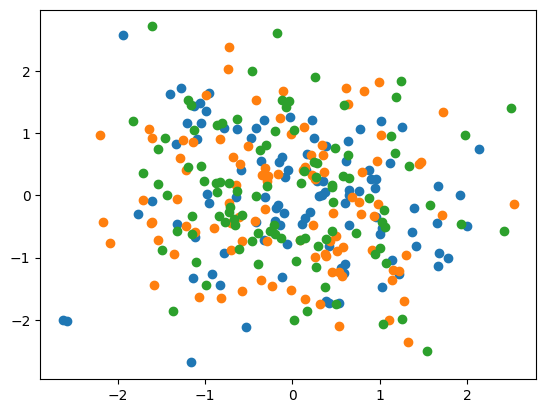

In [200]:
ani = animate_particle_sets(mar_history, n=3, n_steps=50)
ani.save("ani2.gif", writer='imagemagick')

<Axes: >

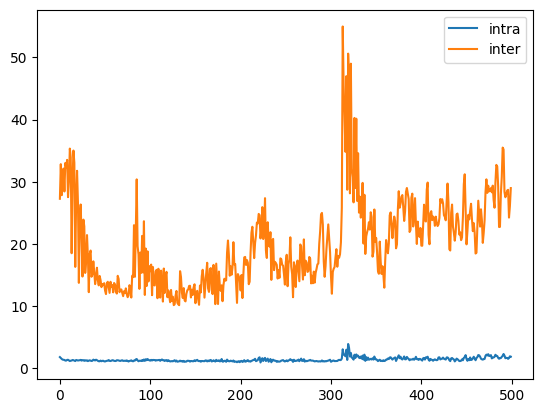

In [201]:
sns.lineplot(x=mar_gp_loss[:,0], y=mar_gp_grads[:,0], label="intra")
sns.lineplot(x=mar_gp_loss[:,0], y=mar_gp_grads[:,1], label="inter")

<Axes: >

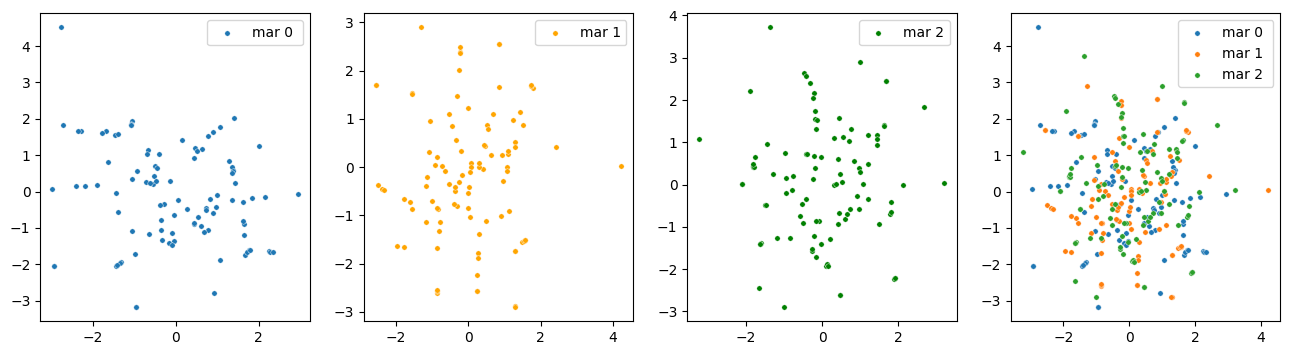

In [202]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
s = 15
sns.scatterplot(x=mar_gp.kernel.w[0, :,0], y=mar_gp.kernel.w[0,:,1], label="mar 0 ", s=s, ax=ax[0])
sns.scatterplot(x=mar_gp.kernel.w[1, :,0], y=mar_gp.kernel.w[1,:,1], label="mar 1", s=s, ax=ax[1], color="orange")
sns.scatterplot(x=mar_gp.kernel.w[2, :,0], y=mar_gp.kernel.w[2,:,1], label="mar 2", s=s, ax=ax[2], color="green")
sns.scatterplot(x=mar_gp.kernel.w[0, :,0], y=mar_gp.kernel.w[0,:,1], label="mar 0 ", s=s, ax=ax[3])
sns.scatterplot(x=mar_gp.kernel.w[1, :,0], y=mar_gp.kernel.w[1,:,1], label="mar 1", s=s, ax=ax[3])
sns.scatterplot(x=mar_gp.kernel.w[2, :,0], y=mar_gp.kernel.w[2,:,1], label="mar 2", s=s, ax=ax[3])
# sns.scatterplot(x=mar_gp.kernel.w[40, :,0], y=mar_gp.kernel.w[40,:,1], label="mar 3", s=s)
# sns.scatterplot(x=mar_gp.kernel.w[45, :,0], y=mar_gp.kernel.w[45,:,1], label="mar 4", s=s)
# sns.scatterplot(x=mar_gp.kernel.w[49, :,0], y=mar_gp.kernel.w[49,:,1], label="mar 5", s=s)
# sns.scatterplot(x=mar_gp.kernel.w[35, :,0], y=mar_gp.kernel.w[35,:,1], label="mar 6", s=s)

# sns.scatterplot(x=srf_gp.kernel.kernel.w[:,0], y=srf_gp.kernel.kernel.w[:,1], label="srf", s=s)

In [ ]:
X_plot_flat = X_plot.reshape(-1, 2)
srf_pred_plot = srf_gp.condition(y_train, X_plot_flat)[0].reshape(n_per_dim, n_per_dim)
mar_pred_plot = mar_gp.condition(key, y_train, X_plot_flat)[0].reshape(n_per_dim, n_per_dim)

<Axes: >

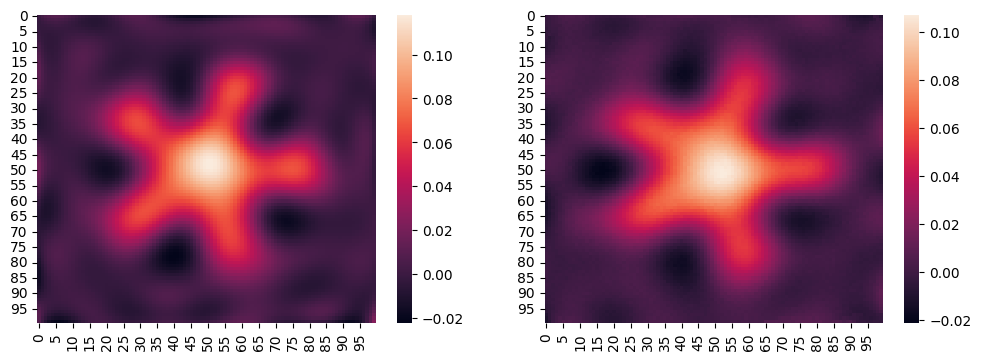

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(srf_pred_plot, ax=ax[0])
sns.heatmap(mar_pred_plot, ax=ax[1])

<Axes: >

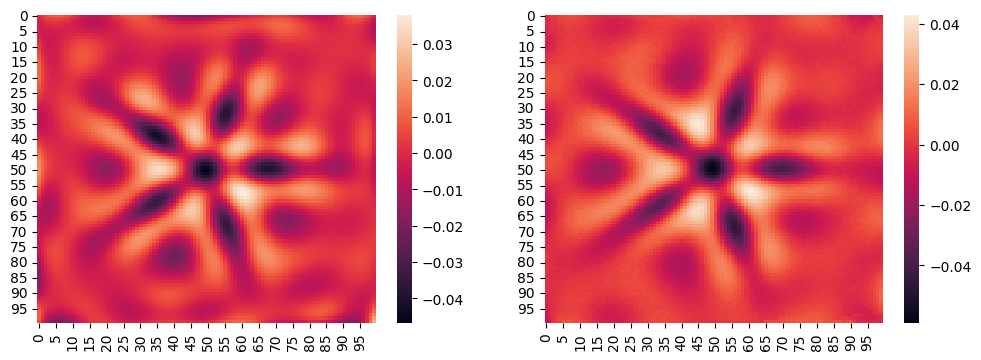

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(srf_pred_plot - y_plot, ax=ax[0])
sns.heatmap(mar_pred_plot - y_plot, ax=ax[1])

<Axes: >

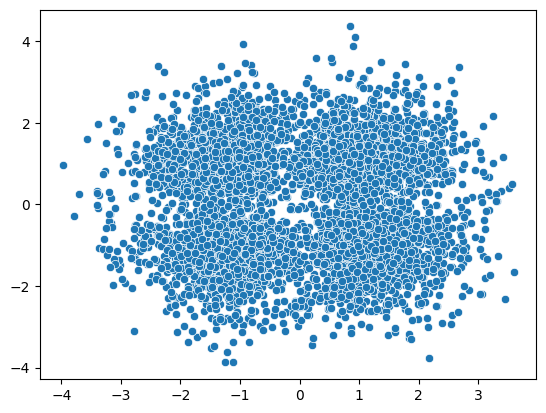

In [ ]:
w_all = mar_gp.kernel.w.reshape(-1, 2)
sns.scatterplot(x=w_all[:,0], y=w_all[:,1])

In [73]:
opt = optax.adam(0.01)
srf_gp_pre = LowRankGP(ARD(jnp.ones(2), RFF(key, d=2, R=100)), X_train, diag=1e-3)
srf_preds_pre, _ = srf_gp_pre.condition(y_train, X_test)
srf_gp, srf_losses, srf_history = srfr(
    srf_gp_pre, y_train, opt, epochs=1000, alpha=0.5, method="matrix", kernel="rbf"
)
srf_preds, _ = srf_gp.condition(y_train, X_test)
srf_history = jnp.array([m.kernel.kernel.w for m in srf_history])

In [74]:
results(y_test, srf_preds_pre, srf_preds)

'MSE Pre: 0.000156; MSE Post: 0.000098'

<Axes: >

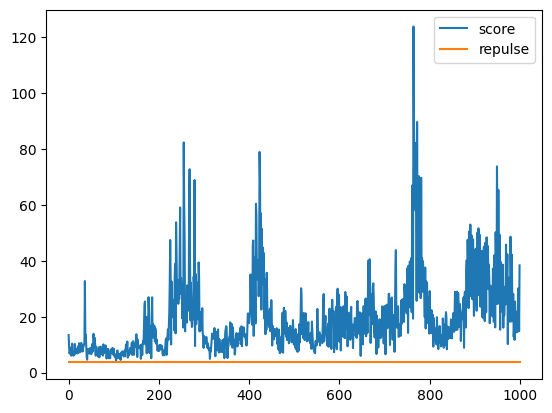

In [75]:
sns.lineplot(x=srf_losses[:,0], y=srf_grads[:,0], label="score")
sns.lineplot(x=srf_losses[:,0], y=srf_grads[:,1], label="repulse")

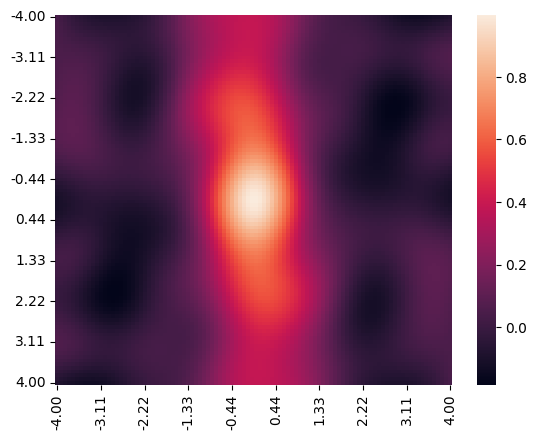

In [76]:
plot_kernel(srf_gp.kernel)

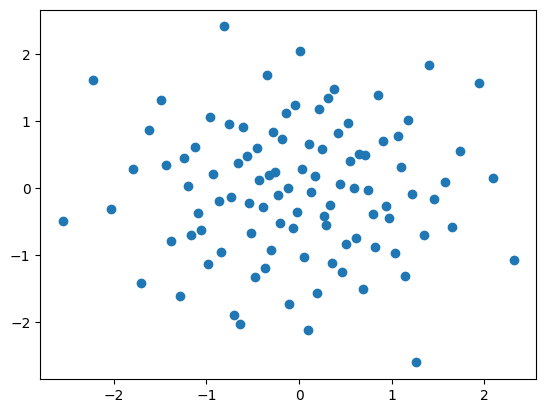

In [77]:
ani = animate_particles(srf_history, n_steps=50)
ani.save("ani.gif", writer='imagemagick')

### More Dev